# Cuda setup
Check if cuda is available.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Import data from source
METHOD 1: install yfinance in the environment hosting python and jupyter. I used Anaconda, and installed through conda terminal into my environment.

*pip install yfinance*

Use the yfinance API to retrieve company data

In [2]:
# yahoo finance api to collect stock data
import yfinance as yf
import os

# datetime imports to work with dates
from datetime import date
from dateutil.relativedelta import relativedelta

# alpaca api to collect stock data
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit

# Process data from csv files
Use pandas library for processing files

Use matplotlib to display graphs and visualizations.

Use torch to create and train a RNN model.

In [3]:
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim.lr_scheduler as lr_scheduler
%matplotlib inline

In [4]:
#Change directory for Lorne's jupyter notebook
# I am mixing windows and wsl on windows so I need to manaually change the directory, so you won't need to when you run it
if True:
    # See files in current directory
    import os

    current_directory = os.getcwd()
    print(current_directory)

    entries = os.listdir('.')
    files = [entry for entry in entries if os.path.isfile(entry)]

    for file_name in files:
        print(file_name)

    %cd "/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS"

    current_directory = os.getcwd()
    print(current_directory)

    entries = os.listdir('.')
    files = [entry for entry in entries if os.path.isfile(entry)]

    # Print the names of the files
    for file_name in files:
        print(file_name)

C:\Users\chr1s\Downloads\Current
AMD_intraday1.csv
model_trained.pt
RNN (0721 Normalization no dropout).ipynb
RNN (0722 Normalized no dropout).ipynb
[WinError 3] The system cannot find the path specified: '/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS'
C:\Users\chr1s\Downloads\Current
C:\Users\chr1s\Downloads\Current
AMD_intraday1.csv
model_trained.pt
RNN (0721 Normalization no dropout).ipynb
RNN (0722 Normalized no dropout).ipynb


# Helper functions
StockDataset class to hold pytorch data

In [5]:
#HYPERPARAMETER
training_percentage = 6
#HYPERPARAMETER
valid_percentage = 2
#HYPERPARAMETER
testing_percentage = 2
class StockDataset(torch.utils.data.Dataset[float]):
    def __init__(self, sequences, targets):
        super(StockDataset).__init__()
        self.sequences = sequences
        self.targets = targets
    def __len__(self):
        return len(self.sequences)    
    def __getitem__(self, index):
        sequence = torch.tensor(self.sequences[index], dtype=torch.float32).unsqueeze(-1)#sequence at index 
        target = torch.tensor(self.targets[index], dtype=torch.float32)#test_value at index
        return sequence, target
        
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, nonlinearity='tanh', bias=True, batch_first=True, dropout=0.0):
        super(RNN, self).__init__()
        self.dropout = nn.Dropout(p=0.5)
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, nonlinearity=nonlinearity, bias=bias, 
            batch_first=batch_first, dropout=dropout, bidirectional=False, device=None, dtype=None)
        self.fc = nn.Linear(128, 1)
        
    def forward(self, x):
        self.dropout(x)
        self.output, self.hidden = self.rnn(x)
        prediction = self.fc(self.output[:, -1, :])
        return prediction.squeeze(-1)

# get_yahoo_stock_data(name, interval="5m", period="7d")

unction that calls yfinance to get stock data from a defined time period

@params stock_name: name of the stock to get data for

@params interval: interval of the data, default is 15 minutes

@params months: number of months to get data for

In [6]:
# Generate stock price data from yahoo finance 
def get_yahoo_stock_data(name, interval="5m", period="7d"):
    data = yf.download(name, interval=interval, period=period)
    return data

# get_alpaca_stock_data(name, interval="15", months="6") 

function calls alpaca api to get stock data for a defined time period starting from June 1st 2021

@params stock_name: name of the stock to get data for

@params interval: interval of the data, default is 15 minutes

@params months: number of months to get data for

In [7]:
# Generate stock price data from alpaca
def get_alpaca_stock_data(name, interval="15", months="6"):
    name_of_file = name + "_intraday1.csv"

    start_date = date(2021, 6, 1)
    end_date = start_date + relativedelta(months=int(months))  # Adds months

    api = REST('PKJ41QP5QU0TYS4S1BYB', 'o5HVFGx0XWSMoMyeQdRJwG1apYXtuMNcguWpjqqe')

    data = api.get_bars(name, TimeFrame(int(interval), TimeFrameUnit.Minute), start_date, end_date, adjustment='raw').df

    data = data.rename(columns={"close": "Close", "open": "Price", "high": "High", "low": "Low", "volume": "Volume", "datetime": "Datetime", "ticker": "Ticker"})

    data.to_csv(name_of_file)

    return name_of_file

# plot_loss(training_loss_array, validation_loss_array, epochs)

Creates a matplotlib plot of the training and validation loss

@params training_loss_array: Array of training loss values

@params validation_loss_array: Array of validation loss values

@params epochs: Number of epochs

In [8]:
# Creates a matplotlib plot of the training and validation loss
def plot_loss(training_loss_array, validation_loss_array, epochs):
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(range(1, int((epochs)/10) + 1), training_loss_array, marker='o', linestyle='-', color='b', label='Training Loss')

    # Plot validation loss
    plt.plot(range(1, int((epochs)/10) + 1), validation_loss_array, marker='x', linestyle='--', color='r', label='Validation Loss')

    # Add title and labels
    plt.title('Training vs Validation Loss Over Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add x-axis ticks
    plt.xticks(range(1, (int((epochs + 1)/10)+1), 1))

    # Show the plot
    plt.show()

# plot_target_vs_predicted_values(target_values_array, predicted_values_array, batch_size)

Creates a matplotlib plot of the target values vs the predicted values.

@params target_values_array: Array of actual real values of selected stock for testing phase of RNN

@params predicted_values_array: Array of predicted values generated by RNN

@params batch_size: Number of values in target_values_array and predicted_values_array

In [9]:
# Creates a matplotlib plot of the training and validation loss
def plot_target_vs_predicted_values(target_values_array, predicted_values_array, batch_size):
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot target values
    plt.plot(range(1, batch_size + 1), target_values_array, marker='o', linestyle='-', color='b', label='Target Values')

    # Plot predicted values
    plt.plot(range(1, batch_size + 1), predicted_values_array, marker='x', linestyle='--', color='r', label='Predicted Values')

    # Add title and labels
    plt.title('Target vs Predicted Stock Values')
    plt.xlabel('Time')
    plt.ylabel('Stock Value')

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add x-axis ticks
    plt.xticks(range(1, batch_size, 1))

    # Show the plot
    plt.show()

# standardize_2d(data)

Standardize the data in a 2D array feed to RNN. It standardizes the data by subtracting the mean and dividing by the standard deviation.

@params data: 2D array of data to be standardized

@returns: Standardized 2D array

In [10]:
def standardize_2d(data):
    # Get the average
    average_val = np.mean(data)

    # Get the standard deviation
    std_val = np.std(data)

    # Subtract the average and divide by the standard deviation
    standardized_data = (data - average_val) / std_val
    return standardized_data

# Display relevant information for formatting purposes

In [11]:
class RNN_initializer:
    #HYPERPARAMETER
    def __init__(self, retrieve, name, recomp, nval, ival, pval, sequence_len, batch_size, num_workers, epochs, learning_rate, lr_scheduler_rate, beta1, beta2):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.learning_rate = learning_rate
        self.lr_scheduler_rate = lr_scheduler_rate
        self.beta1 = beta1
        self.beta2 = beta2

        # Get stock data
        if(retrieve == True): # Retrieve means we call the api calls to get the stock data again. Its computationaly expensive so we don't always retrieve the stock data
            if (stock_data_source == "yahoo"):
                self.csv_name = self.retrieve_csv(name, recomp, nval, str(ival[0])+ival[1], str(pval[0])+pval[1])
            else:
                self.csv_name = get_alpaca_stock_data(name, stock_interval, stock_period)
        else:
            self.csv_name = name

        # We read the CSV createed from the Stock API functions     
        self.df=pd.read_csv(name + "_intraday1.csv")
        #format data, and prepare it for RNN
        if(stock_data_source == "yahoo"):
            price = self.df['Close'].to_list()[2:]
            self.axis_labels = self.df['Price'].to_list()[2:]
        else:
            price = self.df['Close'].to_list()[1:]
            self.axis_labels = self.df['Price'].to_list()[1:]
        date_format_with_time = "%Y-%m-%d %H:%M:%S"

        # Input the data 
        price_inputs = [float(x) for x in price]
        
        # Standardize the data by subtracting the mean of the data and dividing by the standard deviation of the data
        price_inputs = standardize_2d(price_inputs)
        sequence_length = sequence_len
        #Training sets
        train_seq = []
        train_tar = []
        #Validation sets
        valid_seq = []
        valid_tar = []
        #Testing sets
        test_seq = []
        test_tar = []

        # Choose a selected time range
        #HYPERPARAMETERS
        train_range = (len(price_inputs)//10 * training_percentage)
        valid_range_beg = train_range
        valid_range_end = train_range + (len(price_inputs)//10 * valid_percentage)
        test_range_beg = valid_range_end
        test_range_end = valid_range_end + (len(price_inputs)//10 * testing_percentage)
        
        # Generate sequences and targets list for loading data
        for i in range(train_range - sequence_length):
            seq = price_inputs[i:i+sequence_length]
            train_seq.append(seq)
            temp = price_inputs[i+sequence_length]
            train_tar.append(temp)
        for j in range(valid_range_beg, valid_range_end-sequence_length):
            seq = price_inputs[j:j+sequence_length]
            valid_seq.append(seq)
            temp = price_inputs[j+sequence_length]
            valid_tar.append(temp)
        for k in range(test_range_beg, test_range_end-sequence_length):
            seq = price_inputs[k:k+sequence_length]
            test_seq.append(seq)
            temp = price_inputs[k+sequence_length]
            test_tar.append(temp)
        train_data = StockDataset(train_seq, train_tar)
        valid_data = StockDataset(valid_seq, valid_tar)
        test_data = StockDataset(test_seq, test_tar)
        
        # Load training, validation, and testing data
        self.train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
        self.valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
        self.test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
    
    # retreive_csv is a file that allows the user to extract stock data from yahoo finance.
    # @param: name, name of file
    # @param: recomp, indicates if file needs to be recompiled
    # @param: num, indicates which file need to be recompiled
    def retrieve_csv(self, name, recomp, nval, ival, pval):
        # Example: Get 1-minute intraday data for Apple (AAPL) for 1 day
        data = get_yahoo_stock_data(stock_name, stock_interval, stock_period)
        ext = ".csv"
        pt2 = "_intraday"
        num = 1
        file_name = name + pt2 + str(num) + ext
        found = False
        if(recomp!=True):
            while(found!=True):
                if os.path.isfile(file_name):
                    num+=1
                    file_name = name + pt2 + str(num) + ext
                else:
                    found = True
        else:
            if(nval >= 1):
                file_name = name + pt2 + str(nval) + ext
            else:
                file_name = name + pt2 + ext
        data.to_csv(file_name)
        return file_name

    def display_fig(self):
        plt.figure(figsize=(20, 20))
        plt.title(name + " Intraday Stock Price")
        plt.plot(self.axis_labels, self.price_inputs)
        plt.xlabel("time")
        plt.ylabel("price")
        plt.xticks(self.axis_labels[::26])
        plt.yticks(self.price_inputs[::30])
        plt.show()

    def show_df_info(self):
        self.df.head(15)
        self.df.tail(10)
        print("Row count: " + str(len(self.df)))
    def init_RNN(self):
        rnn = RNN()
        return rnn
    def trainAndTest(self, rnn):
        #RNN model
        # move tensors to GPU if CUDA is available
        min_loss = np.inf

        if train_on_gpu:
            rnn.cuda()
        # Use MSELoss instead of MSEAbsoluteLoss (predicting next price compared to next change)
        error = nn.MSELoss()
        # Specify optimizer
        optimizer = torch.optim.Adam(rnn.parameters(), lr=self.learning_rate, betas=(beta1, beta2))
        #optimizer = optim.SGD(model.parameters(), lr=0.01)
        #self.price_tensor = torch.tensor(self.sequences, dtype=torch.float32).unsqueeze(-1)#input 
        #self.y_tensor = torch.tensor(self.test_vals, dtype=torch.float32)#test_values
        
        # Learning rate scheduler, decreases over time
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=self.lr_scheduler_rate, patience=10)
        
        # Variable to keep track of the minimum validation loss
        valid_loss_min = np.inf

        # Training loop
        for epoch in range(epochs):
            train_loss = 0.0
            valid_loss = 0.0
            #TRAINING
            rnn.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                # Move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = rnn(data)
                # Calculate the batch loss
                loss_train = error(output, target)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss_train.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                train_loss += loss_train.item()*data.size(0)
                if (loss_train < min_loss):
                    min_loss = loss_train
                    #torch.save(rnn.state_dict(), "rnn.pth")

            # Update learning rate
            scheduler.step(train_loss)  

    
            ######################    
            # validate the model #
            ######################
            rnn.eval()
            for batch_idx, (data, target) in enumerate(self.valid_loader):
                # Move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = rnn(data)
                # Calculate the batch loss
                loss_valid = error(output, target)
                # Perform a single optimization step (parameter update)
                valid_loss += loss_valid.item()*data.size(0)
                if (loss_valid < min_loss):
                    min_loss = loss_valid
                    #torch.save(rnn.state_dict(), "rnn.pth")

            # Calculate average losses
            train_loss = train_loss/len(self.train_loader.dataset)
            valid_loss = valid_loss/len(self.valid_loader.dataset)
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min and (epoch+1) % 10 == 0:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(rnn.state_dict(), 'model_trained.pt')
                valid_loss_min = valid_loss

            # Print training and validation loss every 10 epochs
            elif (epoch) % 10 == 0:
                lr = optimizer.param_groups[0]["lr"]
                print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss_train.item():.6f}, Validation Loss: {loss_valid.item():.6f}")
                training_loss_array.append(float(loss_train.item()))
                validation_loss_array.append(float(loss_valid.item()))
        
        # Return the minimum loss
        return min_loss
        


In [12]:
# Stock variables used when collecting stock data

# Choose which api to use to grab stock data, either "yahoo" or "alpaca"
stock_data_source = "alpaca"
sequence_len = 4
# Loss array used to store loss values for each 10 epochs, reset each set of hyperparameters
training_loss_array = []
validation_loss_array = []
test_loss = np.inf

#HYPERPARAMETER
# Stock variables when using yahoo finance api
if stock_data_source == "yahoo":
    stock_name = "AMD"
    stock_interval="5m"
    stock_period="7d"
    epochs = 100
    lr_scheduler_rate = 0.8
    beta1 = 0.9
    beta2 = 0.999

#HYPERPARAMETER
# Stock variables when using alpaca api
if stock_data_source == "alpaca":
    stock_name = "AMD"
    stock_interval="15"
    stock_period="12" #months
    epochs = 150
    lr_scheduler_rate = 0.1
    beta1 = 0.9
    #changed
    #beta1 = 0.95
    beta2 = 0.999

batch_size = 16
num_workers = 0

# Setting up control

In [13]:
rnnControlSetup = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], 
    pval=[7,"d"], sequence_len=sequence_len, batch_size=16, num_workers=0, epochs=150, learning_rate=0.001, 
    lr_scheduler_rate=0.1, beta1=0.95, beta2=0.999)
rnnControl = rnnControlSetup.init_RNN()

# Test the lr change



-------------------------------------------------------------------------------
Learning rate:  0.005    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.006561, Validation Loss: 0.558213
Validation loss decreased (inf --> 0.633779).  Saving model ...
Epoch 11/150, Training Loss: 0.044257, Validation Loss: 0.585408
Epoch 21/150, Training Loss: 0.204698, Validation Loss: 1.872846
Validation loss decreased (0.633779 --> 0.053825).  Saving model ...
Epoch 31/150, Training Loss: 0.019105, Validation Loss: 0.065526
Validation loss decreased (0.053825 --> 0.023089).  Saving model ...
Epoch 41/150, Training Loss: 0.001334, Validation Loss: 0.053351
Validation loss decreased (0.023089 --> 0.006429).  Saving model ...
Epoch 51/150, Training Loss: 0.001157, Validati

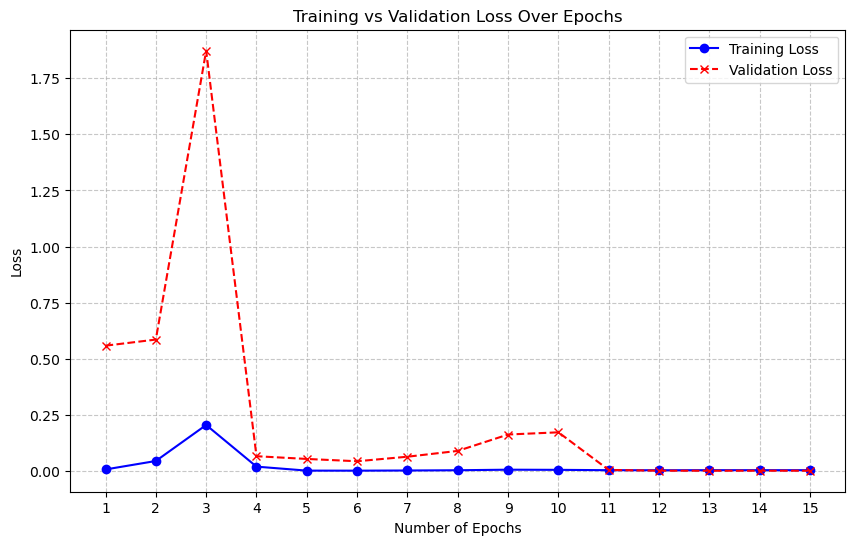



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.056520, Validation Loss: 1.016496
Validation loss decreased (inf --> 1.299705).  Saving model ...
Epoch 11/150, Training Loss: 0.059391, Validation Loss: 1.357481
Validation loss decreased (1.299705 --> 0.109564).  Saving model ...
Epoch 21/150, Training Loss: 0.086109, Validation Loss: 0.058548
Epoch 31/150, Training Loss: 0.009154, Validation Loss: 0.038060
Validation loss decreased (0.109564 --> 0.077322).  Saving model ...
Epoch 41/150, Training Loss: 0.002839, Validation Loss: 0.014149
Epoch 51/150, Training Loss: 0.002529, Validation Loss: 0.027015
Epoch 61/150, Training Loss: 0.004015, Validation L

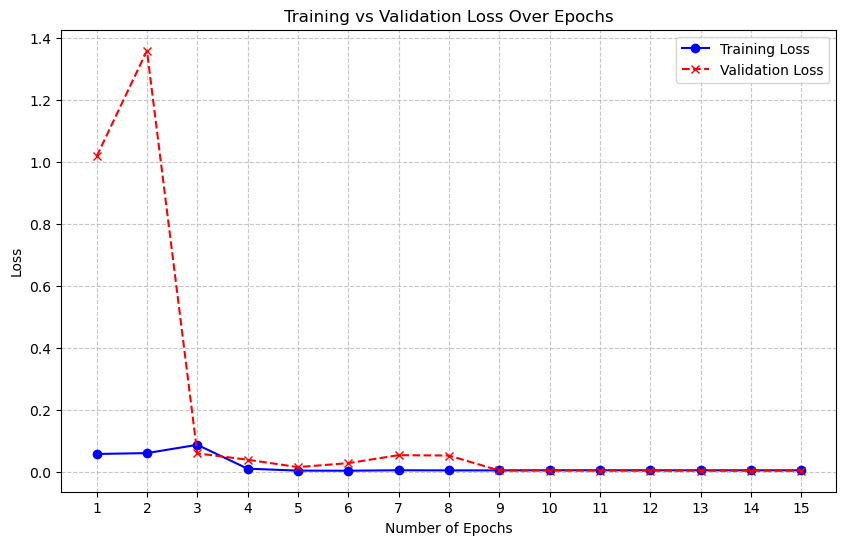



-------------------------------------------------------------------------------
Learning rate:  0.0005    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.089101, Validation Loss: 0.653477
Validation loss decreased (inf --> 0.164359).  Saving model ...
Epoch 11/150, Training Loss: 0.083409, Validation Loss: 0.833486
Validation loss decreased (0.164359 --> 0.019275).  Saving model ...
Epoch 21/150, Training Loss: 0.049864, Validation Loss: 0.000851
Validation loss decreased (0.019275 --> 0.002224).  Saving model ...
Epoch 31/150, Training Loss: 0.003820, Validation Loss: 0.000567
Validation loss decreased (0.002224 --> 0.001295).  Saving model ...
Epoch 41/150, Training Loss: 0.000592, Validation Loss: 0.000521
Validation loss decreased (0.001295 --> 0.0012

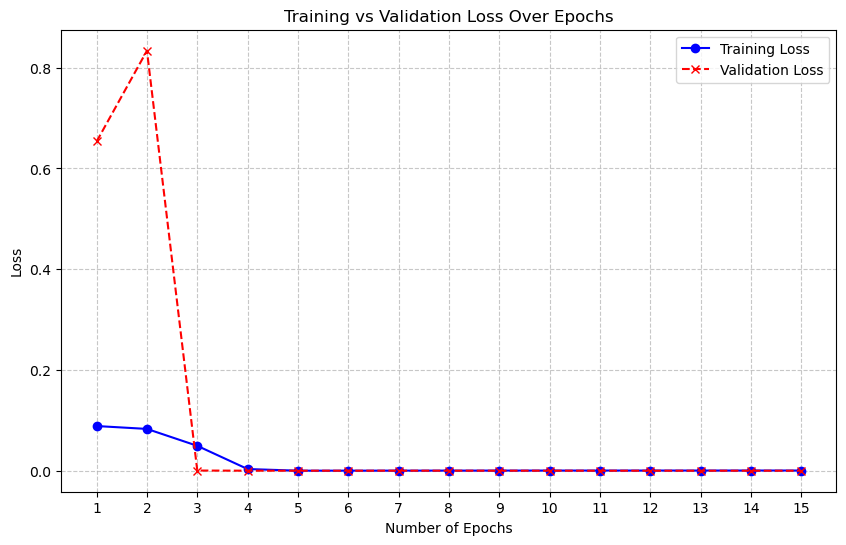



-------------------------------------------------------------------------------
Learning rate:  0.0001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.018278, Validation Loss: 0.232566
Validation loss decreased (inf --> 0.005263).  Saving model ...
Epoch 11/150, Training Loss: 0.005653, Validation Loss: 0.001483
Epoch 21/150, Training Loss: 0.011408, Validation Loss: 0.001835
Validation loss decreased (0.005263 --> 0.004907).  Saving model ...
Epoch 31/150, Training Loss: 0.007114, Validation Loss: 0.001955
Validation loss decreased (0.004907 --> 0.003132).  Saving model ...
Epoch 41/150, Training Loss: 0.004480, Validation Loss: 0.001398
Validation loss decreased (0.003132 --> 0.002328).  Saving model ...
Epoch 51/150, Training Loss: 0.003346, Validat

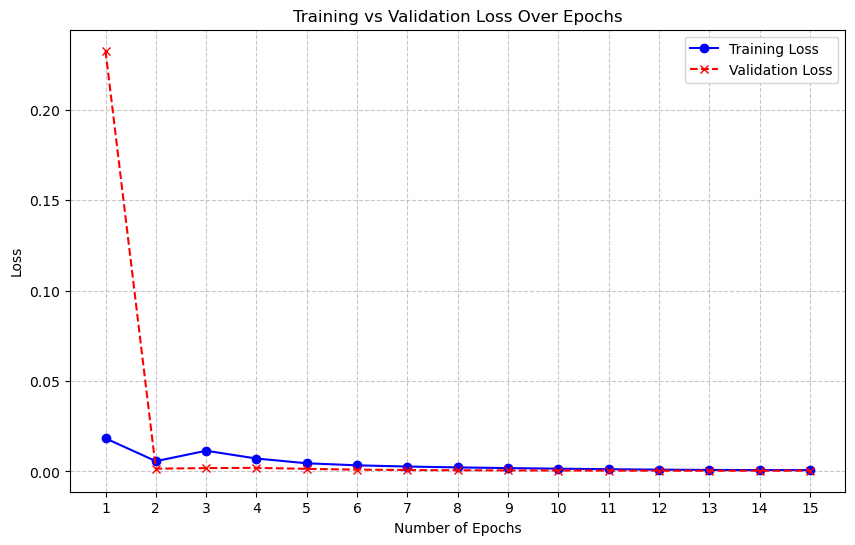



-------------------------------------------------------------------------------
Learning rate:  5e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.039862, Validation Loss: 0.268312
Validation loss decreased (inf --> 0.005254).  Saving model ...
Epoch 11/150, Training Loss: 0.005143, Validation Loss: 0.002724
Validation loss decreased (0.005254 --> 0.003020).  Saving model ...
Epoch 21/150, Training Loss: 0.003187, Validation Loss: 0.000865
Validation loss decreased (0.003020 --> 0.002459).  Saving model ...
Epoch 31/150, Training Loss: 0.002651, Validation Loss: 0.000606
Validation loss decreased (0.002459 --> 0.002109).  Saving model ...
Epoch 41/150, Training Loss: 0.002356, Validation Loss: 0.000517
Validation loss decreased (0.002109 --> 0.00183

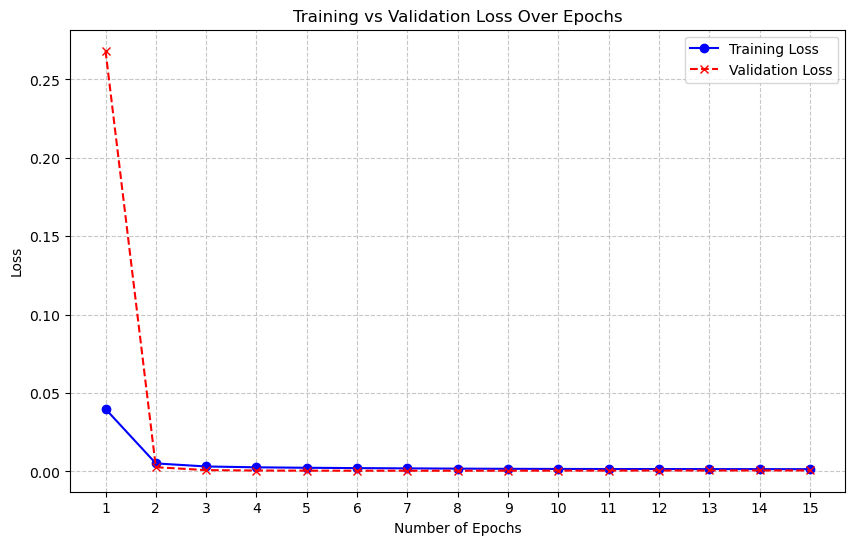



-------------------------------------------------------------------------------
Learning rate:  1e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.017901, Validation Loss: 0.121706
Validation loss decreased (inf --> 0.004243).  Saving model ...
Epoch 11/150, Training Loss: 0.007573, Validation Loss: 0.000867
Validation loss decreased (0.004243 --> 0.003127).  Saving model ...
Epoch 21/150, Training Loss: 0.004693, Validation Loss: 0.000635
Validation loss decreased (0.003127 --> 0.002689).  Saving model ...
Epoch 31/150, Training Loss: 0.003544, Validation Loss: 0.000556
Validation loss decreased (0.002689 --> 0.002403).  Saving model ...
Epoch 41/150, Training Loss: 0.002822, Validation Loss: 0.000511
Validation loss decreased (0.002403 --> 0.00219

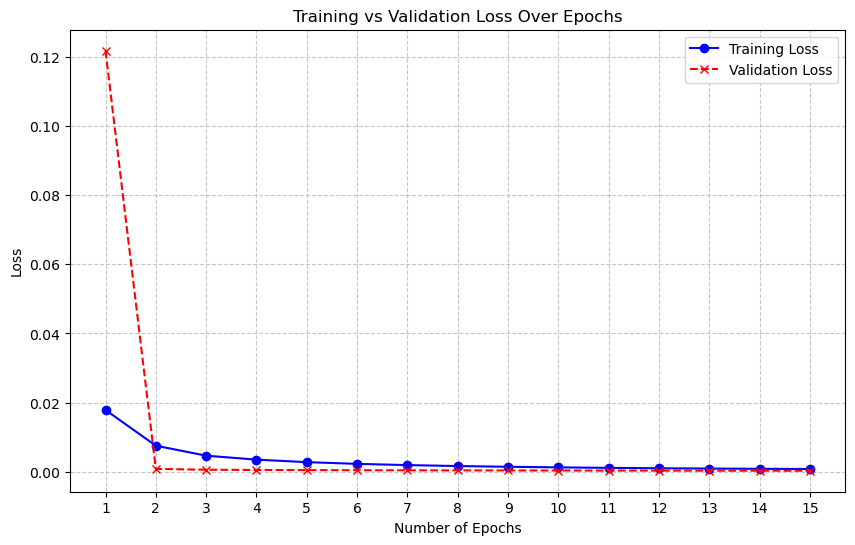



Best learning rate:  1e-05    Loss:  tensor(1.4475e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best learning rate:  0.0001    Loss:  tensor(1.7162e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [25]:
skip_this_step = False

if not skip_this_step:
    #test various learning rates
    learning_rate_list = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001] #revert later for hyperparameter testing, the first few values are not good current set of hyperparameters
    #learning_rate_list = [0.0005, 0.0001, 0.00005, 0.00001]
    best_lr = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_lr_in_loop = np.inf # Capture best learning rate in the loop
    repeated_loops_per_lr = 1
    bestRNN_lr_Setup = [rnnControlSetup,None]
    bestRNN_lr = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for lr in learning_rate_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], sequence_len=sequence_len, batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_lr):
            rnn = rnnSetup.init_RNN()
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnnSetup.trainAndTest(rnn)
            if best_lr_in_loop > loss:
                best_lr_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best lr, remove worst lr from list
        if best_lr_in_loop < best_lr[0][0]:
            best_lr[1] = best_lr[0]
            best_lr[0] = [best_lr_in_loop, lr]
            bestRNN_lr[1] = bestRNN_lr[0]
            bestRNN_lr[0] = bestRNN_in_loop
            bestRNN_lr_Setup[1] =  bestRNN_lr_Setup[0] 
            bestRNN_lr_Setup[0] =  rnnSetup
            #if 
        elif best_lr_in_loop < best_lr[1][0]:
            best_lr[1] = [best_lr_in_loop, lr]
            bestRNN_lr[1] = bestRNN_in_loop
            bestRNN_lr_Setup[1] =  rnnSetup
        best_lr_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest learning rate: ", best_lr[0][1], "   Loss: ", best_lr[0][0])
    print("Second best learning rate: ", best_lr[1][1], "   Loss: ", best_lr[1][0])

skip_this_step = False

# Test beta1 value effect



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.45 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.017892, Validation Loss: 0.198834
Validation loss decreased (inf --> 0.004343).  Saving model ...
Epoch 11/150, Training Loss: 0.004564, Validation Loss: 0.000949
Epoch 21/150, Training Loss: 0.011740, Validation Loss: 0.002051
Epoch 31/150, Training Loss: 0.007790, Validation Loss: 0.001718
Validation loss decreased (0.004343 --> 0.003200).  Saving model ...
Epoch 41/150, Training Loss: 0.005146, Validation Loss: 0.001209
Validation loss decreased (0.003200 --> 0.002419).  Saving model ...
Epoch 51/150, Training Loss: 0.003763, Validation Loss: 0.000875
Validation loss decreased (0.002419 --> 0.002034).

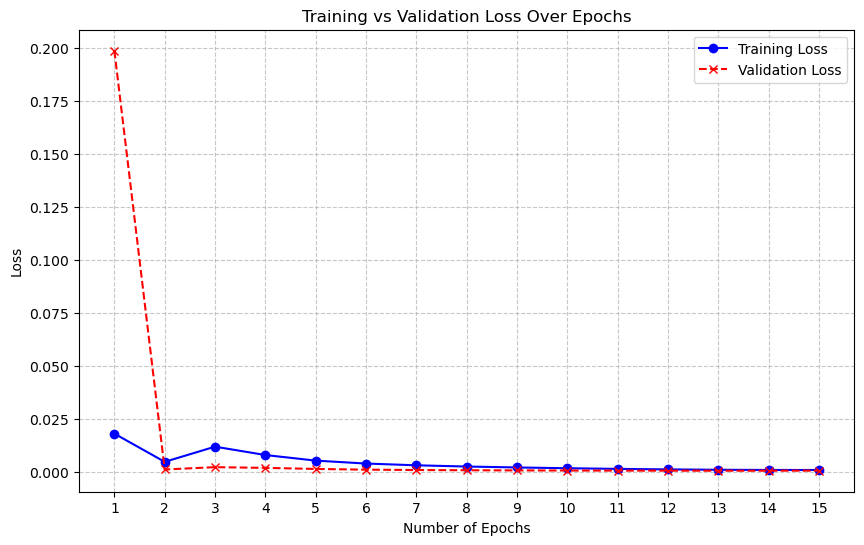



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.7 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.015797, Validation Loss: 0.170358
Validation loss decreased (inf --> 0.004717).  Saving model ...
Epoch 11/150, Training Loss: 0.004693, Validation Loss: 0.001520
Epoch 21/150, Training Loss: 0.013092, Validation Loss: 0.001075
Validation loss decreased (0.004717 --> 0.004365).  Saving model ...
Epoch 31/150, Training Loss: 0.008214, Validation Loss: 0.001119
Validation loss decreased (0.004365 --> 0.002737).  Saving model ...
Epoch 41/150, Training Loss: 0.004893, Validation Loss: 0.000813
Validation loss decreased (0.002737 --> 0.002135).  Saving model ...
Epoch 51/150, Training Loss: 0.003355, Validati

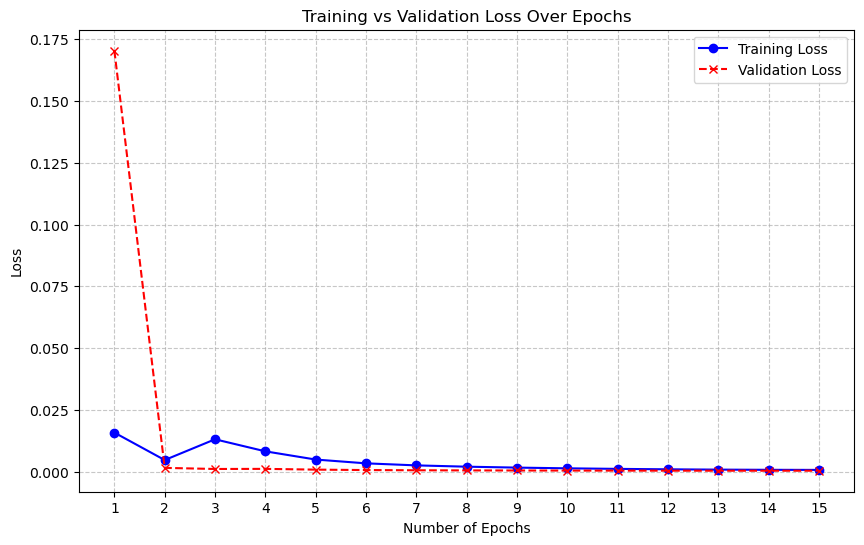



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.017234, Validation Loss: 0.203765
Validation loss decreased (inf --> 0.004678).  Saving model ...
Epoch 11/150, Training Loss: 0.004785, Validation Loss: 0.001196
Epoch 21/150, Training Loss: 0.011214, Validation Loss: 0.001773
Epoch 31/150, Training Loss: 0.007562, Validation Loss: 0.001517
Validation loss decreased (0.004678 --> 0.003125).  Saving model ...
Epoch 41/150, Training Loss: 0.004875, Validation Loss: 0.001179
Validation loss decreased (0.003125 --> 0.002308).  Saving model ...
Epoch 51/150, Training Loss: 0.003476, Validation Loss: 0.000859
Validation loss decreased (0.002308 --> 0.001919). 

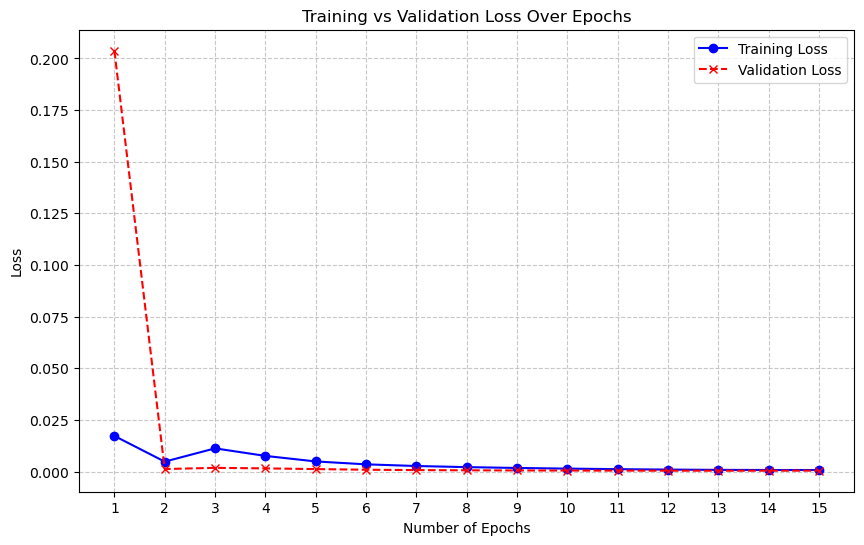



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.017391, Validation Loss: 0.214254
Validation loss decreased (inf --> 0.005508).  Saving model ...
Epoch 11/150, Training Loss: 0.005395, Validation Loss: 0.001711
Epoch 21/150, Training Loss: 0.012249, Validation Loss: 0.001683
Validation loss decreased (0.005508 --> 0.004421).  Saving model ...
Epoch 31/150, Training Loss: 0.007877, Validation Loss: 0.001201
Validation loss decreased (0.004421 --> 0.002983).  Saving model ...
Epoch 41/150, Training Loss: 0.005250, Validation Loss: 0.000865
Validation loss decreased (0.002983 --> 0.002386).  Saving model ...
Epoch 51/150, Training Loss: 0.003942, Validat

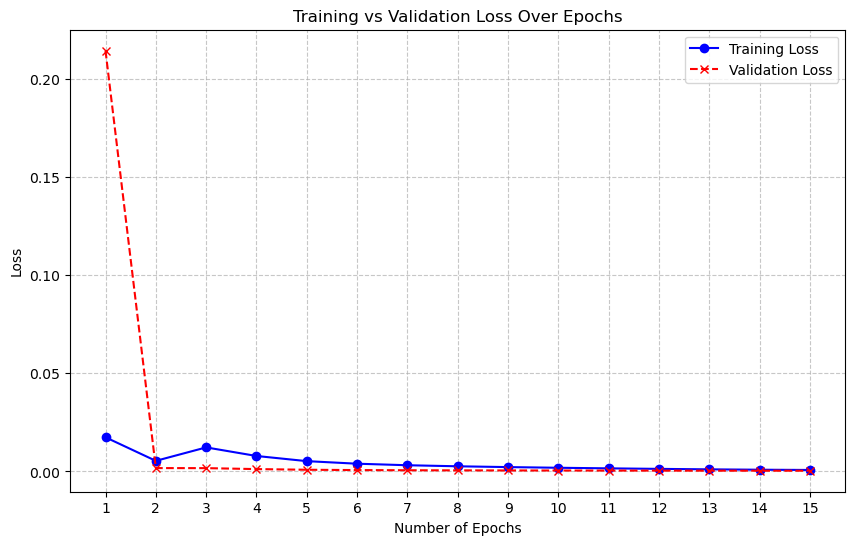



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.99 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.019296, Validation Loss: 0.205355
Validation loss decreased (inf --> 0.004103).  Saving model ...
Epoch 11/150, Training Loss: 0.004186, Validation Loss: 0.000710
Validation loss decreased (0.004103 --> 0.003807).  Saving model ...
Epoch 21/150, Training Loss: 0.002917, Validation Loss: 0.000884
Validation loss decreased (0.003807 --> 0.003787).  Saving model ...
Epoch 31/150, Training Loss: 0.002239, Validation Loss: 0.001359
Validation loss decreased (0.003787 --> 0.002635).  Saving model ...
Epoch 41/150, Training Loss: 0.002313, Validation Loss: 0.000999
Validation loss decreased (0.002635 --> 0.0016

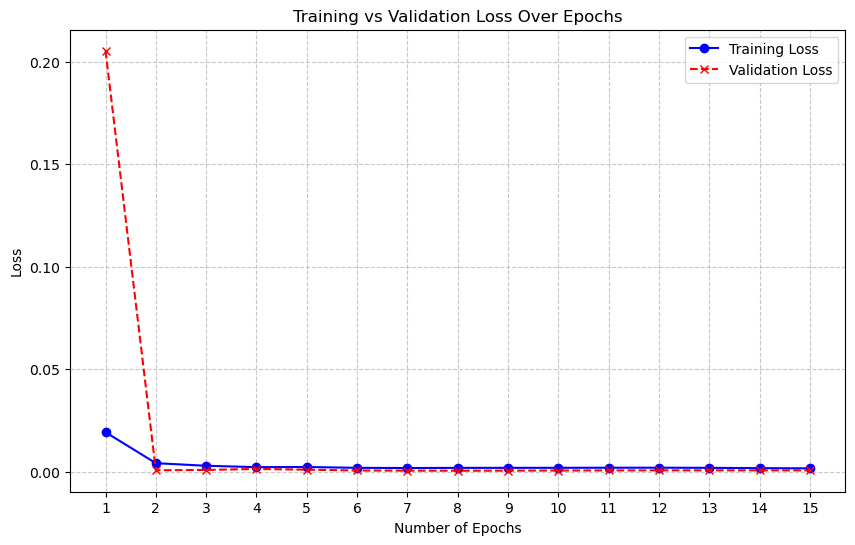



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  1 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.016979, Validation Loss: 0.208455
Validation loss decreased (inf --> 0.008848).  Saving model ...
Epoch 11/150, Training Loss: 0.008381, Validation Loss: 0.004960
Validation loss decreased (0.008848 --> 0.006883).  Saving model ...
Epoch 21/150, Training Loss: 0.012137, Validation Loss: 0.001091
Validation loss decreased (0.006883 --> 0.004159).  Saving model ...
Epoch 31/150, Training Loss: 0.007753, Validation Loss: 0.000903
Validation loss decreased (0.004159 --> 0.002838).  Saving model ...
Epoch 41/150, Training Loss: 0.004959, Validation Loss: 0.000722
Validation loss decreased (0.002838 --> 0.002219)

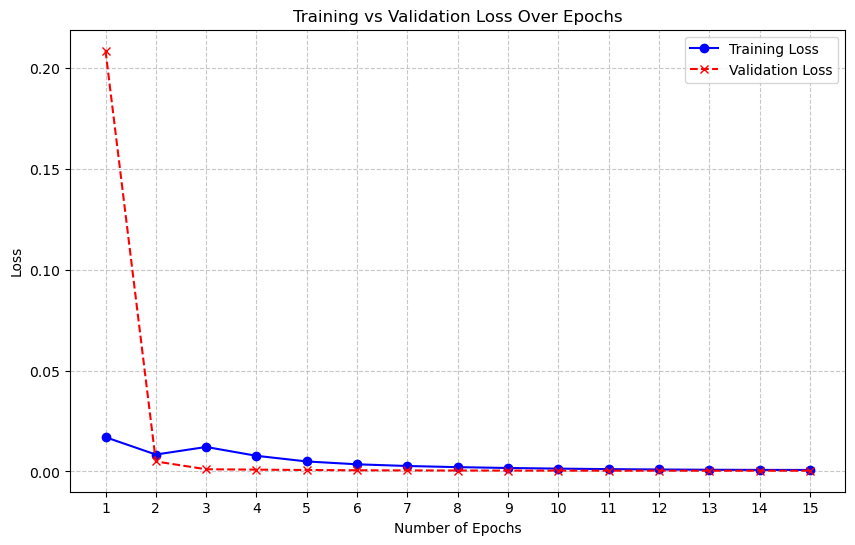



Best beta1:  0.95    Loss:  tensor(1.5938e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best beta1:  0.7    Loss:  tensor(1.6153e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [58]:
skip_this_step = False

if not skip_this_step:
    #test various learning rates
    beta1_list = [0.45, 0.7, 0.9, 0.95, 0.99, 1]
    best_beta1 = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_beta1_in_loop = np.inf
    repeated_loops_per_beta1 = 1
    bestRNN_b1_Setup = [rnnControlSetup,None]
    bestRNN_b1 = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for b1 in beta1_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", 0.001, "   Loop: ", repeated_loops_per_beta1)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", b1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], sequence_len=sequence_len, 
                batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, 
                lr_scheduler_rate=lr_scheduler_rate, beta1=b1, beta2=beta2)
        for i in range(repeated_loops_per_beta1):
            rnn = rnnSetup.init_RNN()
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnnSetup.trainAndTest(rnn)
            if best_beta1_in_loop > loss:
                best_beta1_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best beta1, remove worst beta1 from list
        if best_beta1_in_loop < best_beta1[0][0]:
            best_beta1[1] = best_beta1[0]
            best_beta1[0] = [best_beta1_in_loop, b1]
            bestRNN_b1[1] = bestRNN_b1[0]
            bestRNN_b1[0] = bestRNN_in_loop
            bestRNN_b1_Setup[1] =  bestRNN_b1_Setup[0] 
            bestRNN_b1_Setup[0] =  rnnSetup
            #if 
        elif best_beta1_in_loop < best_beta1[1][0]:
            best_beta1[1] = [best_beta1_in_loop, b1]
            bestRNN_b1[1] = bestRNN_in_loop
            bestRNN_b1_Setup[1] =  rnnSetup
        best_beta1_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest beta1: ", best_beta1[0][1], "   Loss: ", best_beta1[0][0])
    print("Second best beta1: ", best_beta1[1][1], "   Loss: ", best_beta1[1][0])



# Test beta2 value effect



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.5
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.015011, Validation Loss: 0.167851
Validation loss decreased (inf --> 0.004211).  Saving model ...
Epoch 11/150, Training Loss: 0.004669, Validation Loss: 0.000838
Epoch 21/150, Training Loss: 0.011737, Validation Loss: 0.001710
Epoch 31/150, Training Loss: 0.007833, Validation Loss: 0.001167
Validation loss decreased (0.004211 --> 0.003036).  Saving model ...
Epoch 41/150, Training Loss: 0.005392, Validation Loss: 0.000866
Validation loss decreased (0.003036 --> 0.002441).  Saving model ...
Epoch 51/150, Training Loss: 0.004063, Validation Loss: 0.000702
Validation loss decreased (0.002441 --> 0.002105).  S

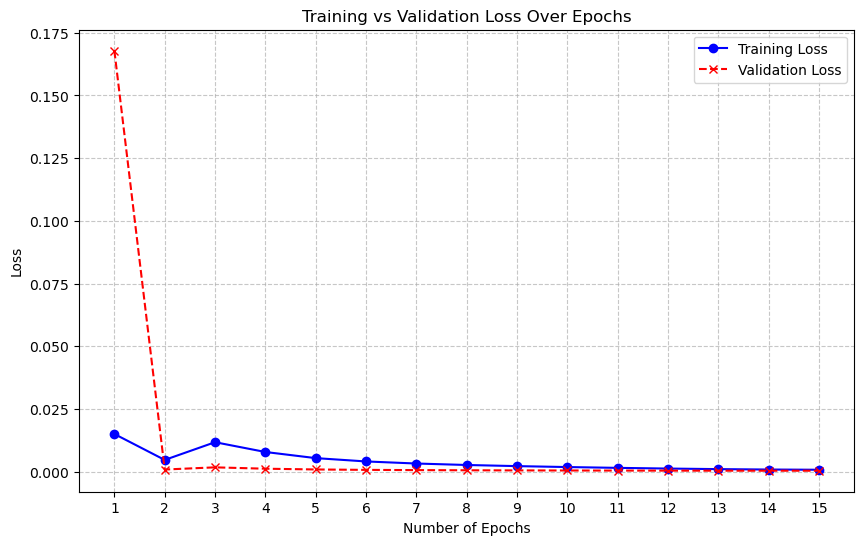



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.9
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.014691, Validation Loss: 0.164459
Validation loss decreased (inf --> 0.005353).  Saving model ...
Epoch 11/150, Training Loss: 0.005753, Validation Loss: 0.001814
Epoch 21/150, Training Loss: 0.010907, Validation Loss: 0.001919
Validation loss decreased (0.005353 --> 0.003926).  Saving model ...
Epoch 31/150, Training Loss: 0.007101, Validation Loss: 0.001133
Validation loss decreased (0.003926 --> 0.002743).  Saving model ...
Epoch 41/150, Training Loss: 0.004869, Validation Loss: 0.000768
Validation loss decreased (0.002743 --> 0.002240).  Saving model ...
Epoch 51/150, Training Loss: 0.003648, Validation

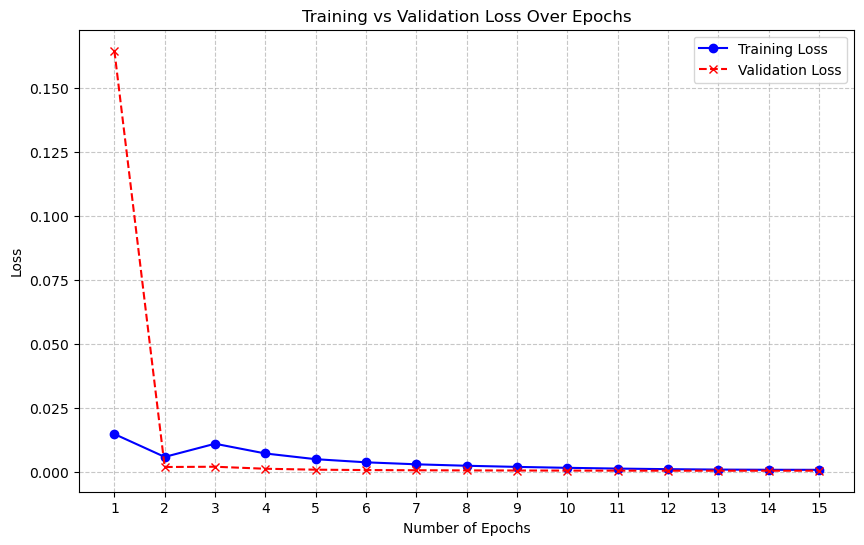



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.99
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.015062, Validation Loss: 0.174308
Validation loss decreased (inf --> 0.006130).  Saving model ...
Epoch 11/150, Training Loss: 0.005885, Validation Loss: 0.002464
Epoch 21/150, Training Loss: 0.011443, Validation Loss: 0.001701
Validation loss decreased (0.006130 --> 0.004194).  Saving model ...
Epoch 31/150, Training Loss: 0.007358, Validation Loss: 0.001145
Validation loss decreased (0.004194 --> 0.002901).  Saving model ...
Epoch 41/150, Training Loss: 0.004938, Validation Loss: 0.000830
Validation loss decreased (0.002901 --> 0.002322).  Saving model ...
Epoch 51/150, Training Loss: 0.003676, Validatio

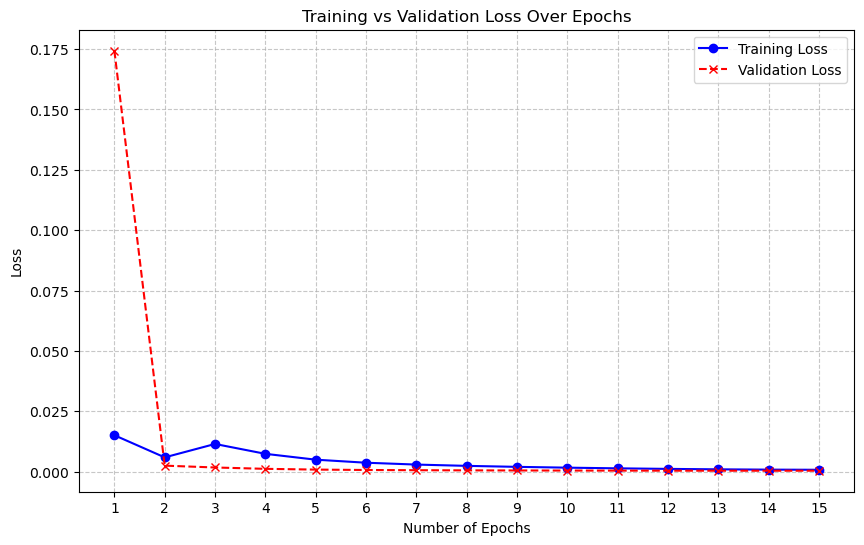



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.018912, Validation Loss: 0.259183
Validation loss decreased (inf --> 0.005592).  Saving model ...
Epoch 11/150, Training Loss: 0.006200, Validation Loss: 0.002214
Epoch 21/150, Training Loss: 0.011024, Validation Loss: 0.001057
Validation loss decreased (0.005592 --> 0.003827).  Saving model ...
Epoch 31/150, Training Loss: 0.006686, Validation Loss: 0.001038
Validation loss decreased (0.003827 --> 0.002528).  Saving model ...
Epoch 41/150, Training Loss: 0.004142, Validation Loss: 0.000788
Validation loss decreased (0.002528 --> 0.002021).  Saving model ...
Epoch 51/150, Training Loss: 0.003040, Validati

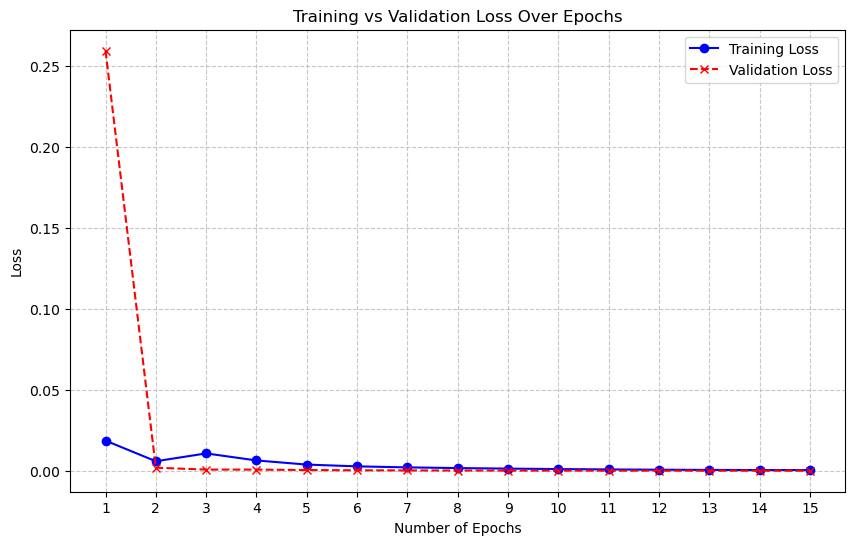



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.9999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.015979, Validation Loss: 0.177236
Validation loss decreased (inf --> 0.005252).  Saving model ...
Epoch 11/150, Training Loss: 0.005583, Validation Loss: 0.001554
Epoch 21/150, Training Loss: 0.012264, Validation Loss: 0.001407
Validation loss decreased (0.005252 --> 0.004601).  Saving model ...
Epoch 31/150, Training Loss: 0.008214, Validation Loss: 0.001203
Validation loss decreased (0.004601 --> 0.003270).  Saving model ...
Epoch 41/150, Training Loss: 0.005559, Validation Loss: 0.000994
Validation loss decreased (0.003270 --> 0.002566).  Saving model ...
Epoch 51/150, Training Loss: 0.004100, Validat

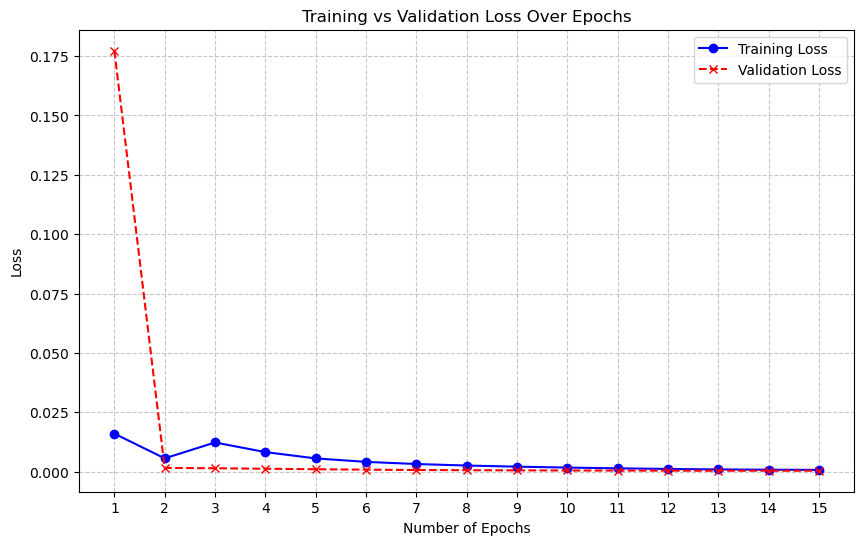



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  1
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.014129, Validation Loss: 0.155963
Validation loss decreased (inf --> 0.005165).  Saving model ...
Epoch 11/150, Training Loss: 0.005510, Validation Loss: 0.001570
Epoch 21/150, Training Loss: 0.012181, Validation Loss: 0.001291
Validation loss decreased (0.005165 --> 0.004041).  Saving model ...
Epoch 31/150, Training Loss: 0.008121, Validation Loss: 0.000869
Validation loss decreased (0.004041 --> 0.002992).  Saving model ...
Epoch 41/150, Training Loss: 0.005694, Validation Loss: 0.000688
Validation loss decreased (0.002992 --> 0.002494).  Saving model ...
Epoch 51/150, Training Loss: 0.004352, Validation L

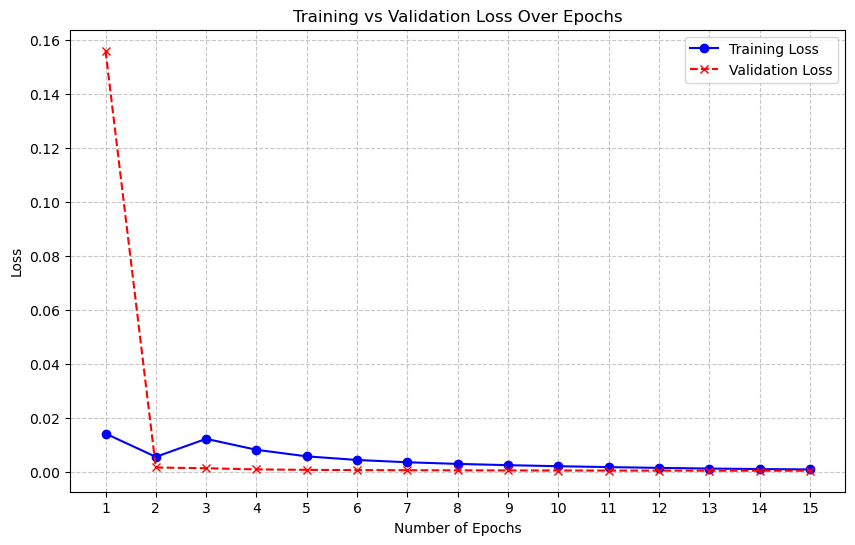



Best beta2:  0.99    Loss:  tensor(1.6007e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best beta2:  0.9999    Loss:  tensor(1.6206e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [59]:
skip_this_step = False
if not skip_this_step:
    #test various learning rates
    beta2_list = [0.5, 0.9, 0.99, 0.999, 0.9999, 1]
    best_beta2 = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_beta2_in_loop = np.inf
    repeated_loops_per_beta2 = 1
    bestRNN_b2_Setup = [rnnControlSetup,None]
    bestRNN_b2 = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for b2 in beta2_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", 0.001, "   Loop: ", repeated_loops_per_beta2)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", b2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], sequence_len=sequence_len,
                    batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, 
                    lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=b2)
        for i in range(repeated_loops_per_beta2):
            rnn = rnnSetup.init_RNN()
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnnSetup.trainAndTest(rnn)
            if best_beta2_in_loop > loss:
                best_beta2_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best beta2, remove worst beta2 from list
        if best_beta2_in_loop < best_beta2[0][0]:
            best_beta2[1] = best_beta2[0]
            best_beta2[0] = [best_beta2_in_loop, b2]
            bestRNN_b2[1] = bestRNN_b2[0]
            bestRNN_b2[0] = bestRNN_in_loop
            bestRNN_b2_Setup[1] =  bestRNN_b2_Setup[0] 
            bestRNN_b2_Setup[0] =  rnnSetup
            #if 
        elif best_beta2_in_loop < best_beta2[1][0]:
            best_beta2[1] = [best_beta2_in_loop, b2]
            bestRNN_b2[1] = bestRNN_in_loop
            bestRNN_b2_Setup[1] =  rnnSetup
        best_beta2_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest beta2: ", best_beta2[0][1], "   Loss: ", best_beta2[0][0])
    print("Second best beta2: ", best_beta2[1][1], "   Loss: ", best_beta2[1][0])

# Test epochs



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.017347, Validation Loss: 0.212171
Validation loss decreased (inf --> 0.005001).  Saving model ...
Epoch 11/150, Training Loss: 0.005072, Validation Loss: 0.001618
Epoch 21/150, Training Loss: 0.011892, Validation Loss: 0.001663
Validation loss decreased (0.005001 --> 0.004783).  Saving model ...
Epoch 31/150, Training Loss: 0.007794, Validation Loss: 0.001635
Validation loss decreased (0.004783 --> 0.003063).  Saving model ...
Epoch 41/150, Training Loss: 0.004853, Validation Loss: 0.001223
Validation loss decreased (0.003063 --> 0.002277).  Saving model ...
Epoch 51/150, Training Loss: 0.003459, Validati

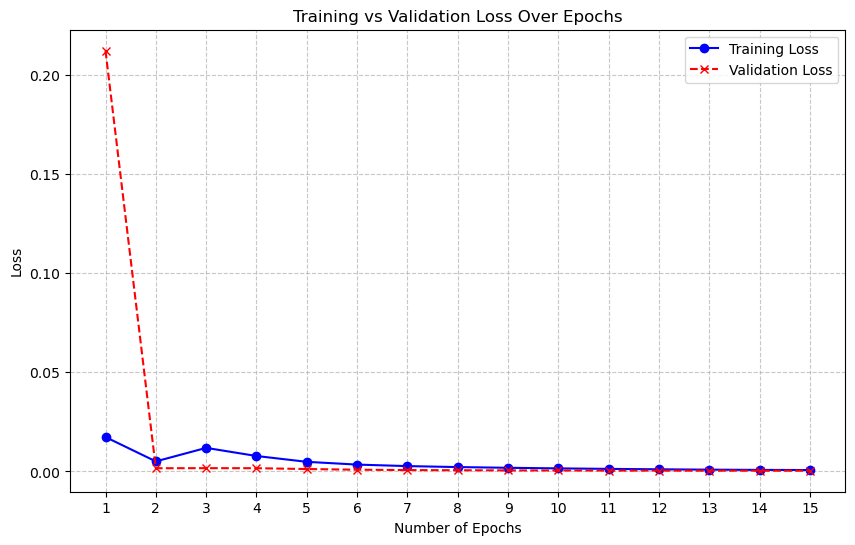



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.017092, Validation Loss: 0.158344
Validation loss decreased (inf --> 0.005766).  Saving model ...
Epoch 11/150, Training Loss: 0.005284, Validation Loss: 0.002527
Epoch 21/150, Training Loss: 0.014439, Validation Loss: 0.000665
Validation loss decreased (0.005766 --> 0.005019).  Saving model ...
Epoch 31/150, Training Loss: 0.009654, Validation Loss: 0.000991
Validation loss decreased (0.005019 --> 0.003274).  Saving model ...
Epoch 41/150, Training Loss: 0.005441, Validation Loss: 0.001112
Validation loss decreased (0.003274 --> 0.002253).  Saving model ...
Epoch 51/150, Training Loss: 0.003551, Validati

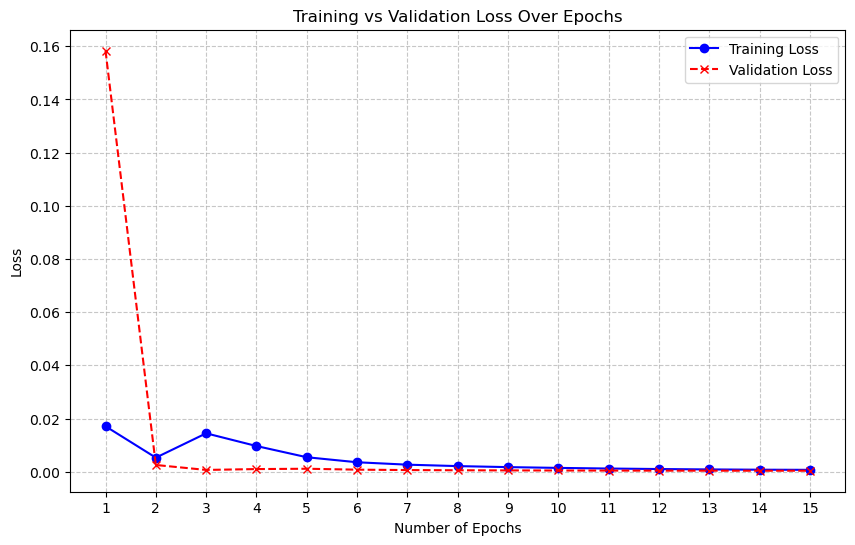



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  200
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.013759, Validation Loss: 0.144451
Validation loss decreased (inf --> 0.005939).  Saving model ...
Epoch 11/150, Training Loss: 0.006308, Validation Loss: 0.001924
Epoch 21/150, Training Loss: 0.011962, Validation Loss: 0.001266
Validation loss decreased (0.005939 --> 0.003936).  Saving model ...
Epoch 31/150, Training Loss: 0.007813, Validation Loss: 0.000823
Validation loss decreased (0.003936 --> 0.002841).  Saving model ...
Epoch 41/150, Training Loss: 0.005334, Validation Loss: 0.000640
Validation loss decreased (0.002841 --> 0.002315).  Saving model ...
Epoch 51/150, Training Loss: 0.003960, Validati

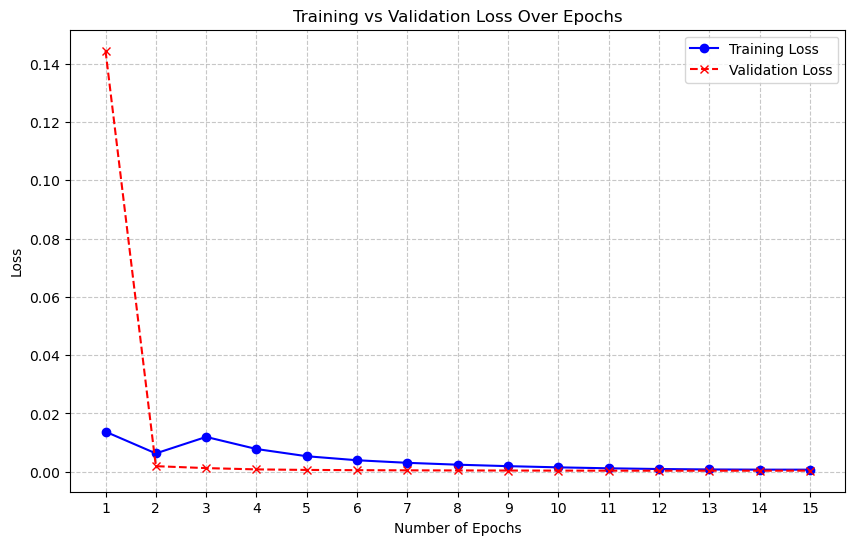



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  300
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.018151, Validation Loss: 0.227017
Validation loss decreased (inf --> 0.005217).  Saving model ...
Epoch 11/150, Training Loss: 0.005506, Validation Loss: 0.001253
Epoch 21/150, Training Loss: 0.011401, Validation Loss: 0.002110
Validation loss decreased (0.005217 --> 0.004957).  Saving model ...
Epoch 31/150, Training Loss: 0.006618, Validation Loss: 0.002144
Validation loss decreased (0.004957 --> 0.002859).  Saving model ...
Epoch 41/150, Training Loss: 0.003988, Validation Loss: 0.001276
Validation loss decreased (0.002859 --> 0.002114).  Saving model ...
Epoch 51/150, Training Loss: 0.002911, Validati

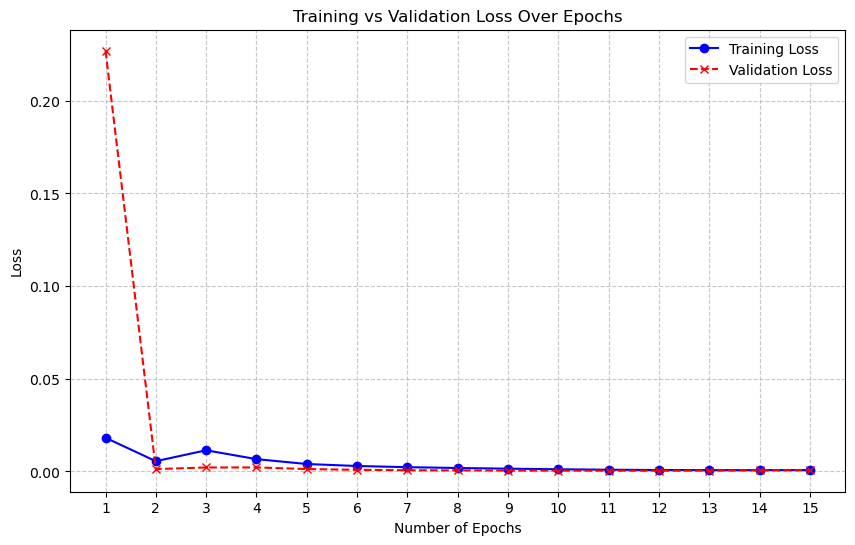



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  400
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.016882, Validation Loss: 0.185828
Validation loss decreased (inf --> 0.004048).  Saving model ...
Epoch 11/150, Training Loss: 0.004434, Validation Loss: 0.000668
Epoch 21/150, Training Loss: 0.012122, Validation Loss: 0.002586
Epoch 31/150, Training Loss: 0.008915, Validation Loss: 0.001976
Validation loss decreased (0.004048 --> 0.003954).  Saving model ...
Epoch 41/150, Training Loss: 0.006549, Validation Loss: 0.001526
Validation loss decreased (0.003954 --> 0.003076).  Saving model ...
Epoch 51/150, Training Loss: 0.005058, Validation Loss: 0.001194
Validation loss decreased (0.003076 --> 0.002566). 

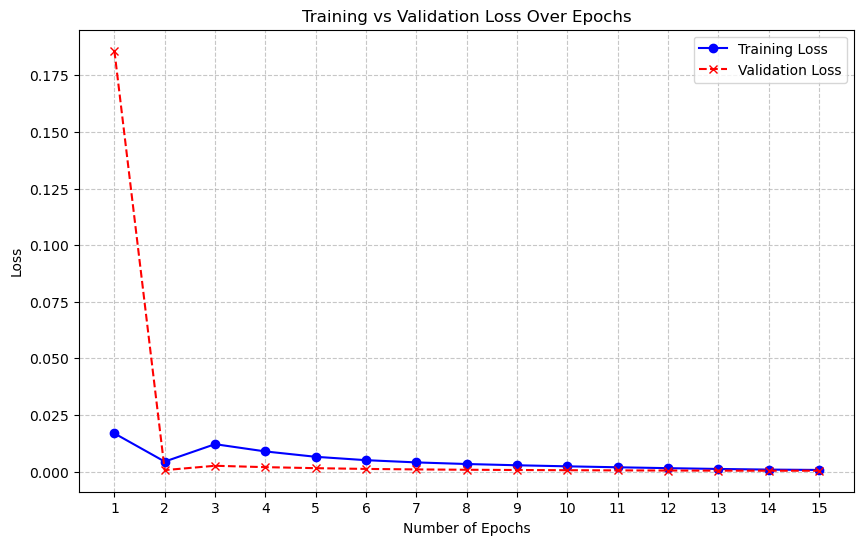



Best epoch:  200    Loss:  tensor(1.5872e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best epoch:  300    Loss:  tensor(1.6066e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [60]:
skip_this_step = False

if not skip_this_step:
    #test various learning rates
    epoch_list = [100, 150, 200, 300, 400] #revert later for hyperparameter testing, the first few values are not good current set of hyperparameters
    #learning_rate_list = [0.0005, 0.0001, 0.00005, 0.00001]
    best_epoch = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_epoch_in_loop = np.inf
    repeated_loops_per_epoch = 1
    bestRNN_ep_Setup = [rnnControlSetup,None]
    bestRNN_ep = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for ep in epoch_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", 0.001, "   Loop: ", repeated_loops_per_epoch)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", ep)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], sequence_len=sequence_len,
                    batch_size=batch_size, num_workers=num_workers, epochs=ep, learning_rate=lr, 
                    lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_epoch):
            rnn = rnnSetup.init_RNN()
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnnSetup.trainAndTest(rnn)
            if best_epoch_in_loop > loss:
                best_epoch_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best epoch, remove worst epoch from list
        if best_epoch_in_loop < best_epoch[0][0]:
            best_epoch[1] = best_epoch[0]
            best_epoch[0] = [best_epoch_in_loop, ep]
            bestRNN_ep[1] = bestRNN_ep[0]
            bestRNN_ep[0] = bestRNN_in_loop
            bestRNN_ep_Setup[1] =  bestRNN_ep_Setup[0] 
            bestRNN_ep_Setup[0] =  rnnSetup
            #if 
        elif best_epoch_in_loop < best_epoch[1][0]:
            best_epoch[1] = [best_epoch_in_loop, ep]
            bestRNN_ep[1] = bestRNN_in_loop
            bestRNN_ep_Setup[1] =  rnnSetup
        best_epoch_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest epoch: ", best_epoch[0][1], "   Loss: ", best_epoch[0][0])
    print("Second best epoch: ", best_epoch[1][1], "   Loss: ", best_epoch[1][0])


# test sequence_size



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
Sequence size:  2
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.010074, Validation Loss: 0.118980
Validation loss decreased (inf --> 0.009376).  Saving model ...
Epoch 11/150, Training Loss: 0.007027, Validation Loss: 0.009676
Validation loss decreased (0.009376 --> 0.002701).  Saving model ...
Epoch 21/150, Training Loss: 0.005238, Validation Loss: 0.000229
Validation loss decreased (0.002701 --> 0.002347).  Saving model ...
Epoch 31/150, Training Loss: 0.004267, Validation Loss: 0.000173
Validation loss decreased (0.002347 --> 0.002121).  Saving model ...
Epoch 41/150, Training Loss: 0.003599, Validation Loss: 0.000128
Validation loss decreased (0.

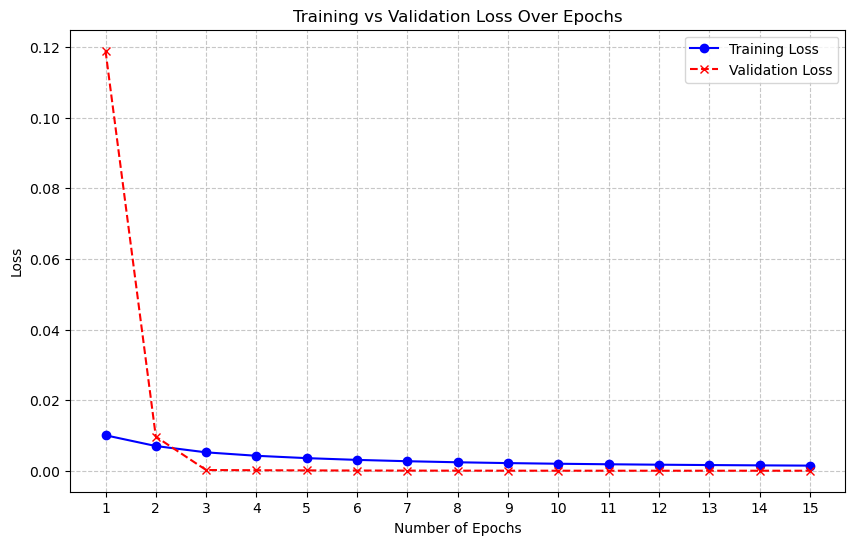



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
Sequence size:  4
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.014355, Validation Loss: 0.137545
Validation loss decreased (inf --> 0.004776).  Saving model ...
Epoch 11/150, Training Loss: 0.004509, Validation Loss: 0.001801
Validation loss decreased (0.004776 --> 0.003602).  Saving model ...
Epoch 21/150, Training Loss: 0.003080, Validation Loss: 0.000569
Validation loss decreased (0.003602 --> 0.003439).  Saving model ...
Epoch 31/150, Training Loss: 0.002351, Validation Loss: 0.000980
Validation loss decreased (0.003439 --> 0.003000).  Saving model ...
Epoch 41/150, Training Loss: 0.001932, Validation Loss: 0.001325
Validation loss decreased (0.

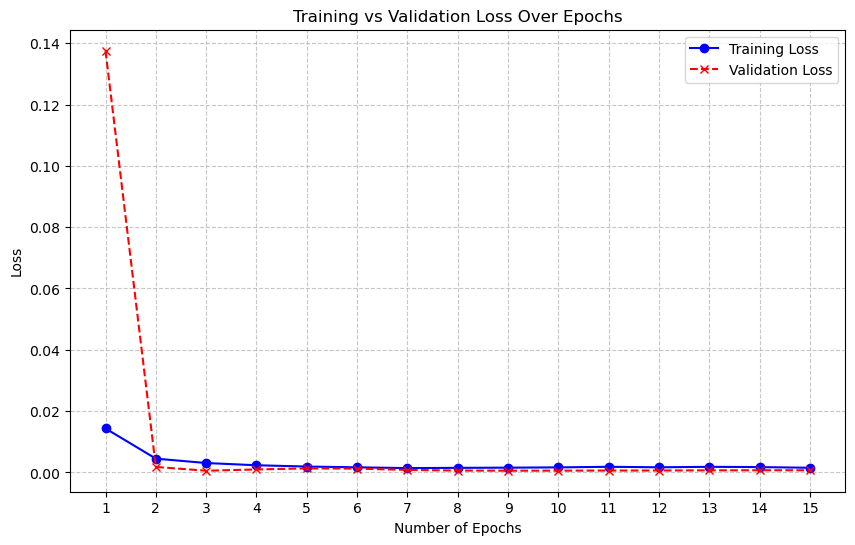



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
Sequence size:  6
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.020214, Validation Loss: 0.168612
Validation loss decreased (inf --> 0.009121).  Saving model ...
Epoch 11/150, Training Loss: 0.008620, Validation Loss: 0.005717
Validation loss decreased (0.009121 --> 0.003314).  Saving model ...
Epoch 21/150, Training Loss: 0.003635, Validation Loss: 0.000404
Validation loss decreased (0.003314 --> 0.002057).  Saving model ...
Epoch 31/150, Training Loss: 0.003044, Validation Loss: 0.000256
Validation loss decreased (0.002057 --> 0.001823).  Saving model ...
Epoch 41/150, Training Loss: 0.002578, Validation Loss: 0.000279
Validation loss decreased (0.

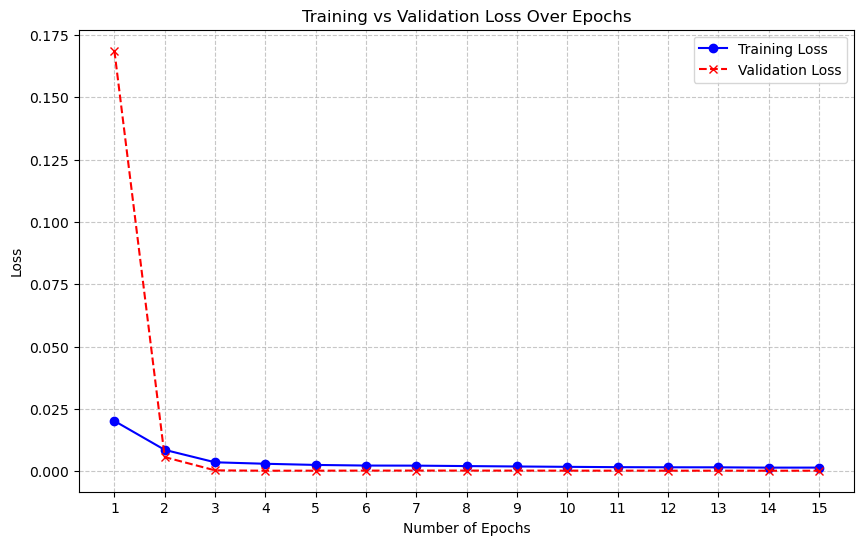



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
Sequence size:  8
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.034241, Validation Loss: 0.340018
Validation loss decreased (inf --> 0.028064).  Saving model ...
Epoch 11/150, Training Loss: 0.021064, Validation Loss: 0.026097
Validation loss decreased (0.028064 --> 0.004553).  Saving model ...
Epoch 21/150, Training Loss: 0.004518, Validation Loss: 0.001293
Validation loss decreased (0.004553 --> 0.002674).  Saving model ...
Epoch 31/150, Training Loss: 0.003624, Validation Loss: 0.000438
Validation loss decreased (0.002674 --> 0.002070).  Saving model ...
Epoch 41/150, Training Loss: 0.003600, Validation Loss: 0.000366
Validation loss decreased (0.

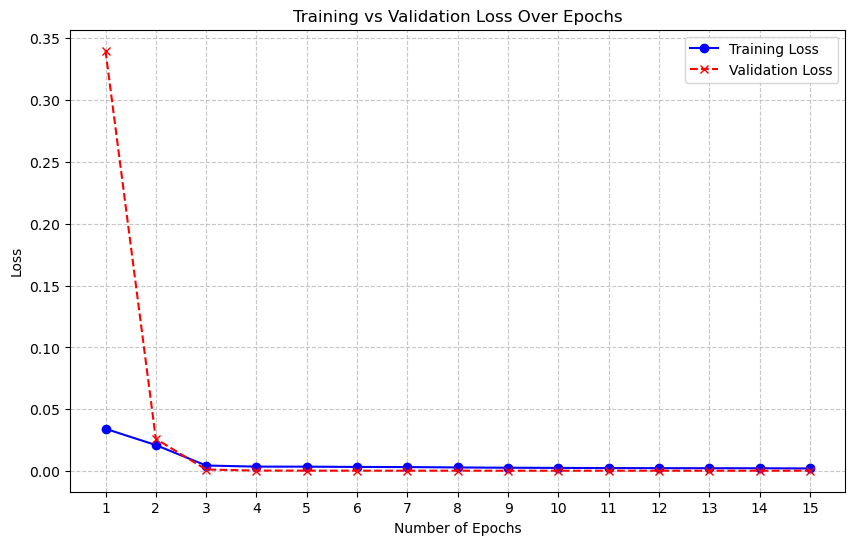



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
Sequence size:  10
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.029778, Validation Loss: 0.356741
Validation loss decreased (inf --> 0.007945).  Saving model ...
Epoch 11/150, Training Loss: 0.006063, Validation Loss: 0.005662
Validation loss decreased (0.007945 --> 0.003245).  Saving model ...
Epoch 21/150, Training Loss: 0.004234, Validation Loss: 0.001305
Validation loss decreased (0.003245 --> 0.002270).  Saving model ...
Epoch 31/150, Training Loss: 0.002461, Validation Loss: 0.000372
Validation loss decreased (0.002270 --> 0.001939).  Saving model ...
Epoch 41/150, Training Loss: 0.002193, Validation Loss: 0.000296
Validation loss decreased (0

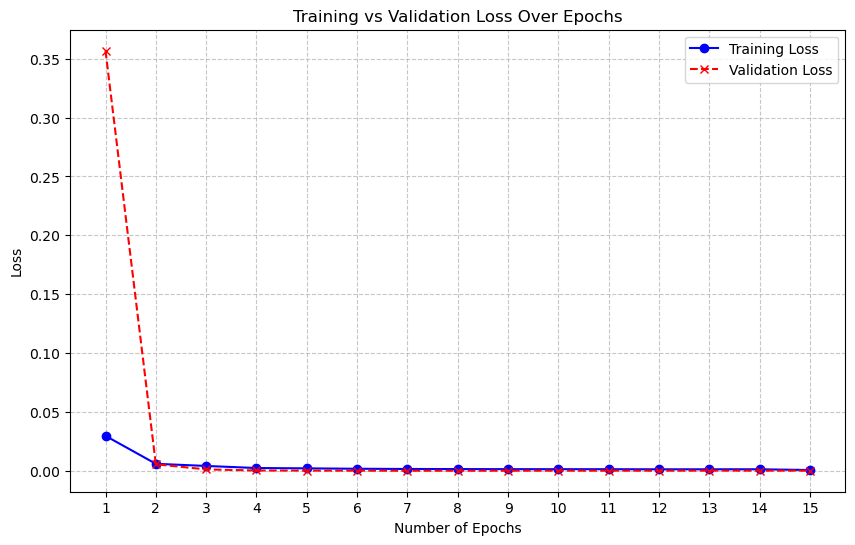



Best sequence:  8    Loss:  tensor(8.4582e-07, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best sequence:  10    Loss:  tensor(1.5090e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [61]:
skip_this_step = False
if not skip_this_step:
    #test various learning rates
    seq_list = [2, 4, 6, 8, 10] #revert later for hyperparameter testing, the first few values are not good current set of hyperparameters
    #learning_rate_list = [0.0005, 0.0001, 0.00005, 0.00001]
    best_seq = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_seq_in_loop = np.inf
    repeated_loops_per_seq = 1
    bestRNN_seq_Setup = [rnnControlSetup,None]
    bestRNN_seq = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for seq in seq_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", 0.001, "   Loop: ", repeated_loops_per_epoch)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("Sequence size: ", seq)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], 
                    batch_size=batch_size, sequence_len=seq, num_workers=num_workers, epochs=epochs, learning_rate=lr, 
                    lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_seq):
            rnn = rnnSetup.init_RNN()
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnnSetup.trainAndTest(rnn)
            if best_seq_in_loop > loss:
                best_seq_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best lr, remove worst lr from list
        if best_seq_in_loop < best_seq[0][0]:
            best_seq[1] = best_seq[0]
            best_seq[0] = [best_seq_in_loop, seq]
            bestRNN_seq[1] = bestRNN_seq[0]
            bestRNN_seq[0] = bestRNN_in_loop
            bestRNN_seq_Setup[1] =  bestRNN_seq_Setup[0] 
            bestRNN_seq_Setup[0] =  rnnSetup
            #if 
        elif best_seq_in_loop < best_seq[1][0]:
            best_seq[1] = [best_seq_in_loop, seq]
            bestRNN_seq[1] = bestRNN_in_loop
            bestRNN_seq_Setup[1] =  rnnSetup
        best_seq_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest sequence: ", best_seq[0][1], "   Loss: ", best_seq[0][0])
    print("Second best sequence: ", best_seq[1][1], "   Loss: ", best_seq[1][0])


# Find best optimized LR



-------------------------------------------------------------------------------
Learning rate:  1e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.049070, Validation Loss: 0.080112
Validation loss decreased (inf --> 0.003522).  Saving model ...
Epoch 11/150, Training Loss: 0.005496, Validation Loss: 0.000673
Validation loss decreased (0.003522 --> 0.002802).  Saving model ...
Epoch 21/150, Training Loss: 0.003583, Validation Loss: 0.000575
Validation loss decreased (0.002802 --> 0.002505).  Saving model ...
Epoch 31/150, Training Loss: 0.002856, Validation Loss: 0.000530
Validation loss decreased (0.002505 --> 0.002297).  Saving model ...
Epoch 41/150, Training Loss: 0.002387, Validation Loss: 0.000498
Validation loss decreased (0.002297 --> 0.00213

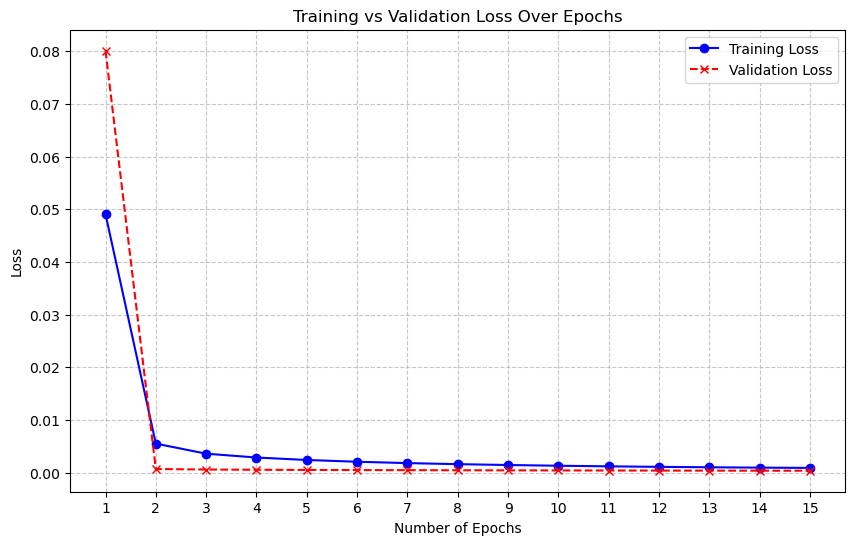



-------------------------------------------------------------------------------
Learning rate:  1.9e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.055828, Validation Loss: 0.192273
Validation loss decreased (inf --> 0.003171).  Saving model ...
Epoch 11/150, Training Loss: 0.003533, Validation Loss: 0.000665
Validation loss decreased (0.003171 --> 0.002496).  Saving model ...
Epoch 21/150, Training Loss: 0.002203, Validation Loss: 0.000529
Validation loss decreased (0.002496 --> 0.002218).  Saving model ...
Epoch 31/150, Training Loss: 0.001722, Validation Loss: 0.000504
Validation loss decreased (0.002218 --> 0.002014).  Saving model ...
Epoch 41/150, Training Loss: 0.001447, Validation Loss: 0.000483
Validation loss decreased (0.002014 --> 0.001

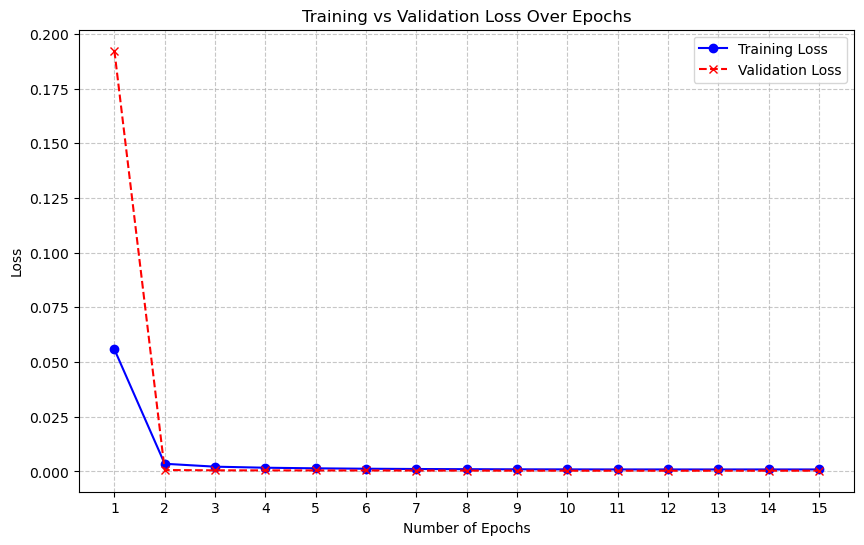



-------------------------------------------------------------------------------
Learning rate:  2.8000000000000003e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.093643, Validation Loss: 0.313821
Validation loss decreased (inf --> 0.002738).  Saving model ...
Epoch 11/150, Training Loss: 0.002080, Validation Loss: 0.000579
Validation loss decreased (0.002738 --> 0.002328).  Saving model ...
Epoch 21/150, Training Loss: 0.001734, Validation Loss: 0.000502
Validation loss decreased (0.002328 --> 0.002065).  Saving model ...
Epoch 31/150, Training Loss: 0.001585, Validation Loss: 0.000462
Validation loss decreased (0.002065 --> 0.001870).  Saving model ...
Epoch 41/150, Training Loss: 0.001507, Validation Loss: 0.000441
Validation loss decreased (0.0

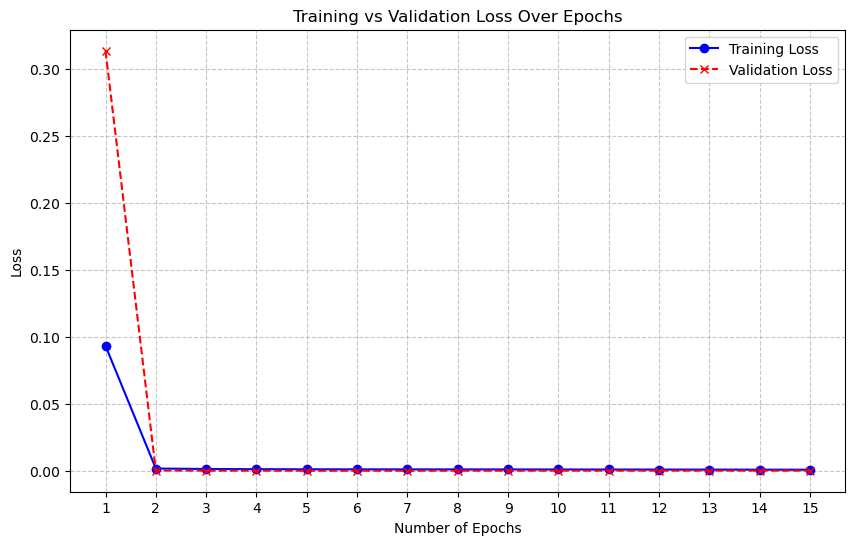



-------------------------------------------------------------------------------
Learning rate:  3.7e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.056803, Validation Loss: 0.228092
Validation loss decreased (inf --> 0.003025).  Saving model ...
Epoch 11/150, Training Loss: 0.002863, Validation Loss: 0.000732
Validation loss decreased (0.003025 --> 0.002451).  Saving model ...
Epoch 21/150, Training Loss: 0.002152, Validation Loss: 0.000512
Validation loss decreased (0.002451 --> 0.002168).  Saving model ...
Epoch 31/150, Training Loss: 0.001879, Validation Loss: 0.000466
Validation loss decreased (0.002168 --> 0.001945).  Saving model ...
Epoch 41/150, Training Loss: 0.001768, Validation Loss: 0.000440
Validation loss decreased (0.001945 --> 0.001

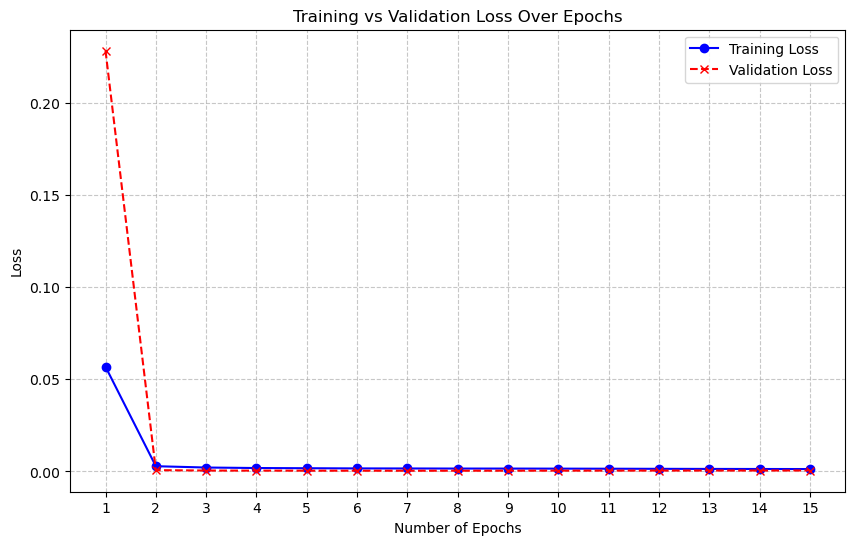



-------------------------------------------------------------------------------
Learning rate:  4.6e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.046794, Validation Loss: 0.265440
Validation loss decreased (inf --> 0.003623).  Saving model ...
Epoch 11/150, Training Loss: 0.003831, Validation Loss: 0.001134
Validation loss decreased (0.003623 --> 0.002622).  Saving model ...
Epoch 21/150, Training Loss: 0.002563, Validation Loss: 0.000535
Validation loss decreased (0.002622 --> 0.002224).  Saving model ...
Epoch 31/150, Training Loss: 0.002230, Validation Loss: 0.000483
Validation loss decreased (0.002224 --> 0.001959).  Saving model ...
Epoch 41/150, Training Loss: 0.002099, Validation Loss: 0.000470
Validation loss decreased (0.001959 --> 0.001

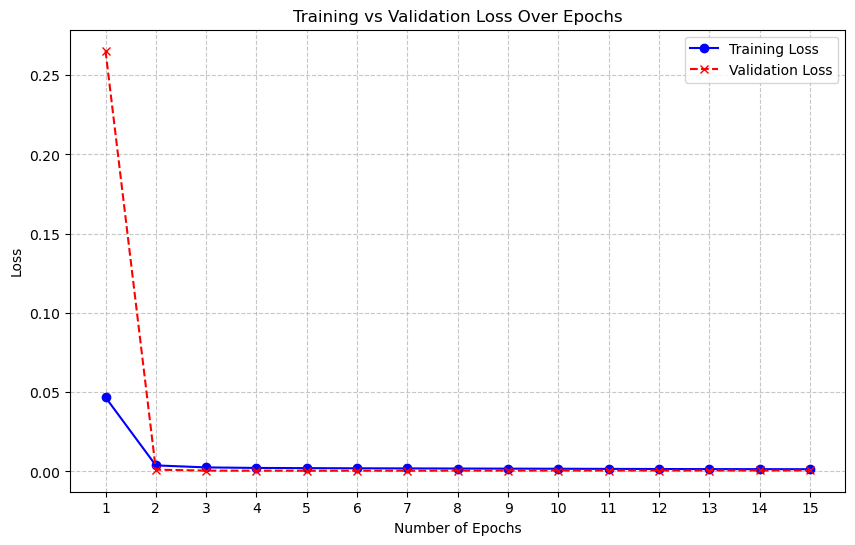



-------------------------------------------------------------------------------
Learning rate:  5.5e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.021373, Validation Loss: 0.170096
Validation loss decreased (inf --> 0.005230).  Saving model ...
Epoch 11/150, Training Loss: 0.005689, Validation Loss: 0.002433
Validation loss decreased (0.005230 --> 0.005048).  Saving model ...
Epoch 21/150, Training Loss: 0.008059, Validation Loss: 0.001280
Validation loss decreased (0.005048 --> 0.003875).  Saving model ...
Epoch 31/150, Training Loss: 0.006376, Validation Loss: 0.001089
Validation loss decreased (0.003875 --> 0.003125).  Saving model ...
Epoch 41/150, Training Loss: 0.005112, Validation Loss: 0.000913
Validation loss decreased (0.003125 --> 0.002

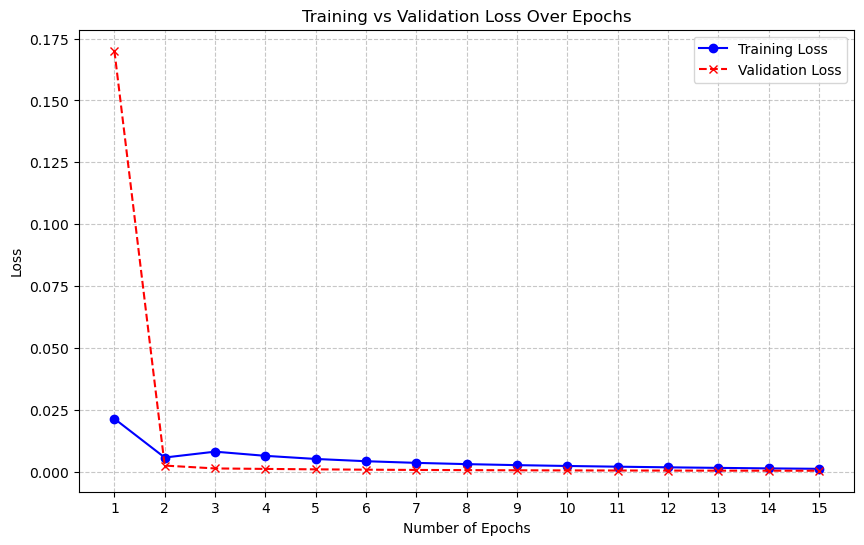



-------------------------------------------------------------------------------
Learning rate:  6.4e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.013893, Validation Loss: 0.118653
Validation loss decreased (inf --> 0.004662).  Saving model ...
Epoch 11/150, Training Loss: 0.004902, Validation Loss: 0.001568
Epoch 21/150, Training Loss: 0.010910, Validation Loss: 0.000802
Epoch 31/150, Training Loss: 0.008441, Validation Loss: 0.001044
Validation loss decreased (0.004662 --> 0.003794).  Saving model ...
Epoch 41/150, Training Loss: 0.006241, Validation Loss: 0.001249
Validation loss decreased (0.003794 --> 0.002936).  Saving model ...
Epoch 51/150, Training Loss: 0.004630, Validation Loss: 0.001109
Validation loss decreased (0.002936 --> 0.002413)

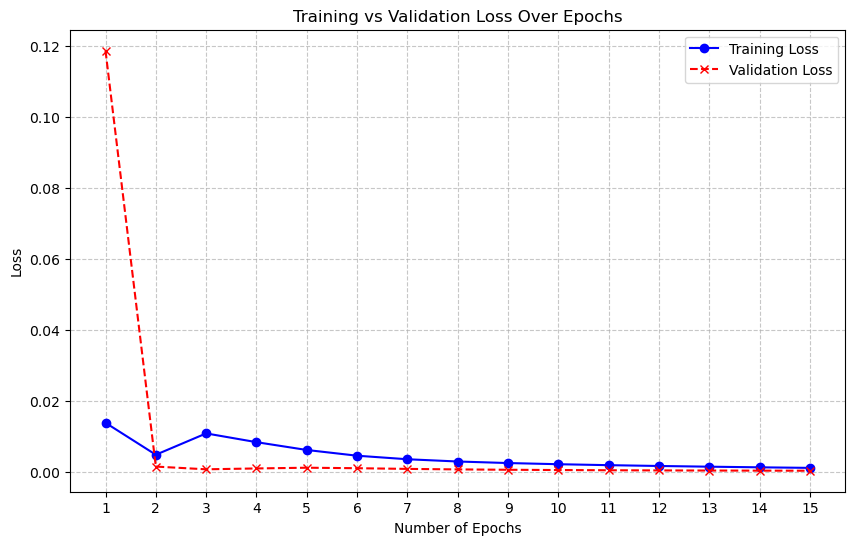



-------------------------------------------------------------------------------
Learning rate:  7.3e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.013763, Validation Loss: 0.144334
Validation loss decreased (inf --> 0.006077).  Saving model ...
Epoch 11/150, Training Loss: 0.005899, Validation Loss: 0.002654
Epoch 21/150, Training Loss: 0.011923, Validation Loss: 0.000928
Validation loss decreased (0.006077 --> 0.004765).  Saving model ...
Epoch 31/150, Training Loss: 0.008706, Validation Loss: 0.001078
Validation loss decreased (0.004765 --> 0.003594).  Saving model ...
Epoch 41/150, Training Loss: 0.006042, Validation Loss: 0.001128
Validation loss decreased (0.003594 --> 0.002757).  Saving model ...
Epoch 51/150, Training Loss: 0.004391, Valida

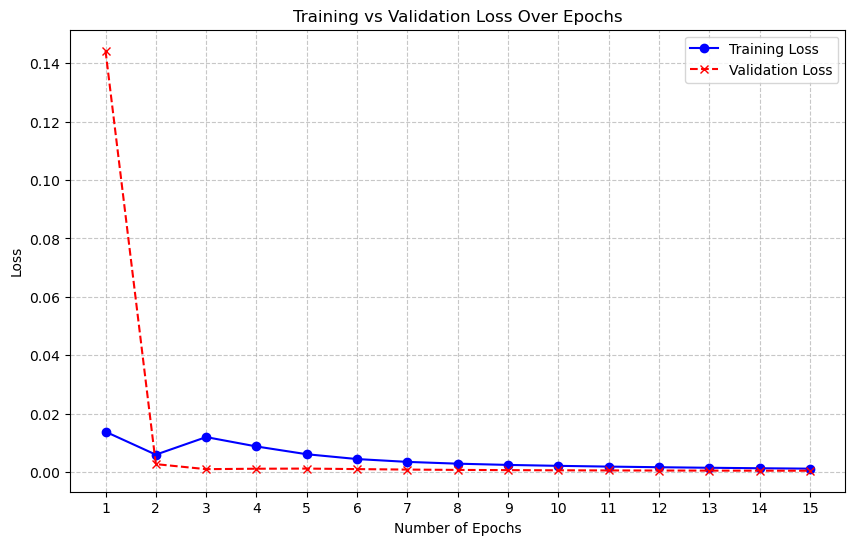



-------------------------------------------------------------------------------
Learning rate:  8.2e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.019369, Validation Loss: 0.220645
Validation loss decreased (inf --> 0.005928).  Saving model ...
Epoch 11/150, Training Loss: 0.006078, Validation Loss: 0.002457
Validation loss decreased (0.005928 --> 0.005812).  Saving model ...
Epoch 21/150, Training Loss: 0.010233, Validation Loss: 0.001420
Validation loss decreased (0.005812 --> 0.003754).  Saving model ...
Epoch 31/150, Training Loss: 0.007136, Validation Loss: 0.000929
Validation loss decreased (0.003754 --> 0.002826).  Saving model ...
Epoch 41/150, Training Loss: 0.005161, Validation Loss: 0.000716
Validation loss decreased (0.002826 --> 0.002

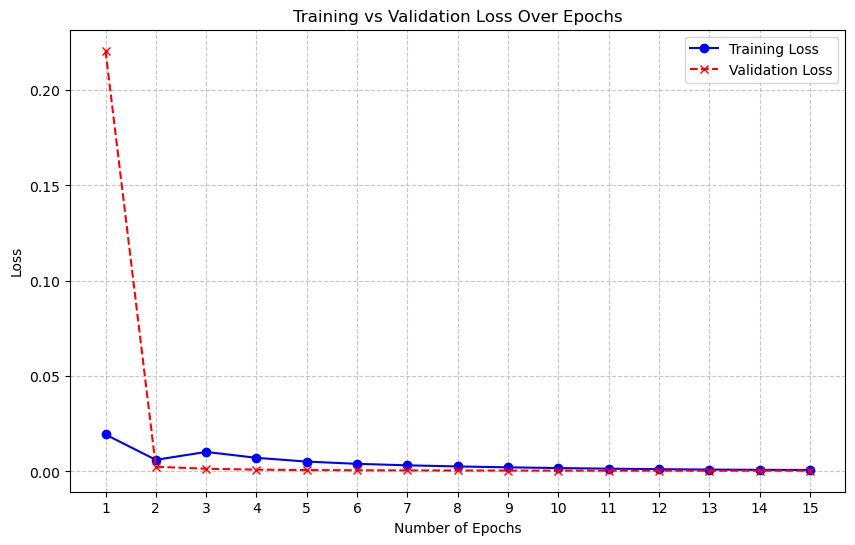



-------------------------------------------------------------------------------
Learning rate:  9.1e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.016908, Validation Loss: 0.197193
Validation loss decreased (inf --> 0.004534).  Saving model ...
Epoch 11/150, Training Loss: 0.004684, Validation Loss: 0.001064
Epoch 21/150, Training Loss: 0.013107, Validation Loss: 0.001527
Epoch 31/150, Training Loss: 0.008611, Validation Loss: 0.001272
Validation loss decreased (0.004534 --> 0.003102).  Saving model ...
Epoch 41/150, Training Loss: 0.005601, Validation Loss: 0.000939
Validation loss decreased (0.003102 --> 0.002404).  Saving model ...
Epoch 51/150, Training Loss: 0.004063, Validation Loss: 0.000742
Validation loss decreased (0.002404 --> 0.002055)

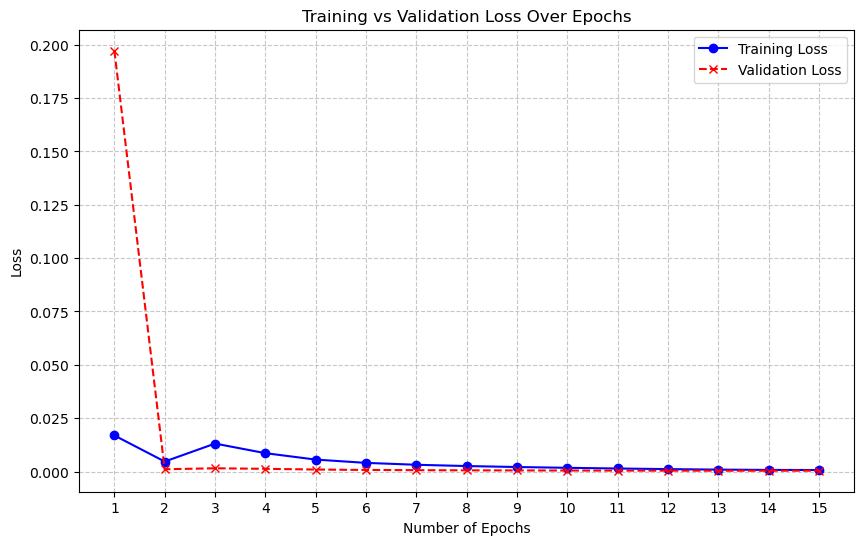



Best optimized learning rate:  1e-05    Loss:  tensor(1.3635e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best optimized learning rate:  5.5e-05    Loss:  tensor(1.5594e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [47]:
skip_this_step = False

if not skip_this_step:
    learning_rate_list = []
    difference_of_lr = best_lr[0][1] - best_lr[1][1]
    number_of_increments = 10
    increment = difference_of_lr / number_of_increments
    
    optRNN_lr_Setup = [rnnControlSetup,None]
    optRNN_lr = [rnnControl,None]
    opt_lr = [[np.inf, np.inf] , [np.inf, np.inf]]
    best_lr_in_loop = np.inf
    for i in range(number_of_increments):
        learning_rate_list.append(best_lr[0][1] - increment * i)

    for lr in learning_rate_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")

        
        rnnSetup = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], sequence_len=sequence_len, batch_size=batch_size, 
            num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_lr):
            training_loss_array = []
            validation_loss_array = []
            rnn = rnnSetup.init_RNN()
            loss = rnnSetup.trainAndTest(rnn)
            if best_lr_in_loop > loss:
                best_lr_in_loop = loss

        if best_lr_in_loop < opt_lr[0][0]:
            opt_lr[1] = opt_lr[0]
            opt_lr[0] = [best_lr_in_loop, lr]
            optRNN_lr_Setup[1] =  optRNN_lr_Setup[0]
            optRNN_lr_Setup[0] = rnnSetup
            optRNN_lr[1] = optRNN_lr[0]
            optRNN_lr[0] = rnn
        elif best_lr_in_loop < opt_lr[1][0]:
            opt_lr[1] = [best_lr_in_loop, lr]
            optRNN_lr_Setup[1] = rnnSetup
            optRNN_lr[1] = rnn
        best_lr_in_loop = np.inf


        plot_loss(training_loss_array, validation_loss_array, epochs)


    print("\n\nBest optimized learning rate: ", opt_lr[0][1], "   Loss: ", opt_lr[0][0])
    print("Second best optimized learning rate: ", opt_lr[1][1], "   Loss: ", opt_lr[1][0])

skip_this_step = False

In [48]:
#Stock variables when using yahoo finance api
if stock_data_source == "yahoo":
    stock_name = "AMD"
    stock_interval="5m"
    stock_period="7d"
    epochs = 100
    lr_scheduler_rate = 0.8
    beta1 = 0.9
    beta2 = 0.999

#Stock variables when using alpaca api
if stock_data_source == "alpaca":
    stock_name = "AMD"
    stock_interval="15"
    stock_period="12" #months
    epochs = 150
    lr_scheduler_rate = 0.1
    beta1 = 0.9
    beta2 = 0.999

batch_size = 16
num_workers = 0

In [49]:
#Stock variables when using yahoo finance api
if stock_data_source == "yahoo":
    stock_name = "AMD"
    stock_interval="5m"
    stock_period="7d"
    epochs = 100
    lr_scheduler_rate = 0.8
    beta1 = 0.9
    beta2 = 0.999

#Stock variables when using alpaca api
if stock_data_source == "alpaca":
    stock_name = "AMD"
    stock_interval="15"
    stock_period="12" #months
    epochs = 150
    lr_scheduler_rate = 0.1
    beta1 = 0.90
    beta2 = 0.999

batch_size = 16
num_workers = 0

# Full test dataset on Trained RNN with optimized LR hyperparameter

In [52]:
test_loss = 0.0
value_correct = 0
error = nn.MSELoss()
#print(optRNN_lr_Setup)
print("\n\n-------------------------------------------------------------------------------")
print("Learning rate: ", opt_lr[0][1])
print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
print("Learning rate scheduler rate: ", lr_scheduler_rate)
print("Beta1: ", beta1, "Beta2: ", beta2)
print("-------------------------------------------------------------------------------")
optRNN_lr[0].eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(optRNN_lr_Setup[0].test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = optRNN_lr[0](data)
    # calculate the batch loss
    loss = error(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # compare predictions to true label
    correct_tensor = output.eq(target.data.view_as(output))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    value_correct += 1
        
# average test loss
test_loss = test_loss/len(optRNN_lr_Setup[0].test_loader.dataset)
print('Average Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: %f (%2d/%2d)' % (value_correct/len(optRNN_lr_Setup[0].test_loader.dataset),
    value_correct, len(optRNN_lr_Setup[0].test_loader.dataset)))



-------------------------------------------------------------------------------
Learning rate:  1e-05
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Average Test Loss: 0.000870

Test Accuracy: 0.062500 (195/3120)




-------------------------------------------------------------------------------
Target Values vs Predicted Values: 
Stock:  AMD
Batch size:  16
Target Values  [-0.48688235878944397, -0.4816160500049591, -0.5249276757240295, -0.5283729434013367, -0.5273885726928711, -0.5303416848182678, -0.5303416848182678, -0.5303367376327515, -0.5264042615890503, -0.5268964171409607, -0.5332947373390198, -0.5323103666305542, -0.5268964171409607, -0.5318182110786438, -0.5337868928909302, -0.5362477898597717]
Output Values  [-0.4832720458507538, -0.48280802369117737, -0.48337414860725403, -0.504607081413269, -0.521172285079956, -0.5247687697410583, -0.5281839370727539, -0.5292564630508423, -0.5294285416603088, -0.5274525284767151, -0.5263932943344116, -0.5296923518180847, -0.5311794877052307, -0.5284457802772522, -0.5294695496559143, -0.5317339897155762]
Test Loss:  0.0008703136521944543
-------------------------------------------------------------------------------


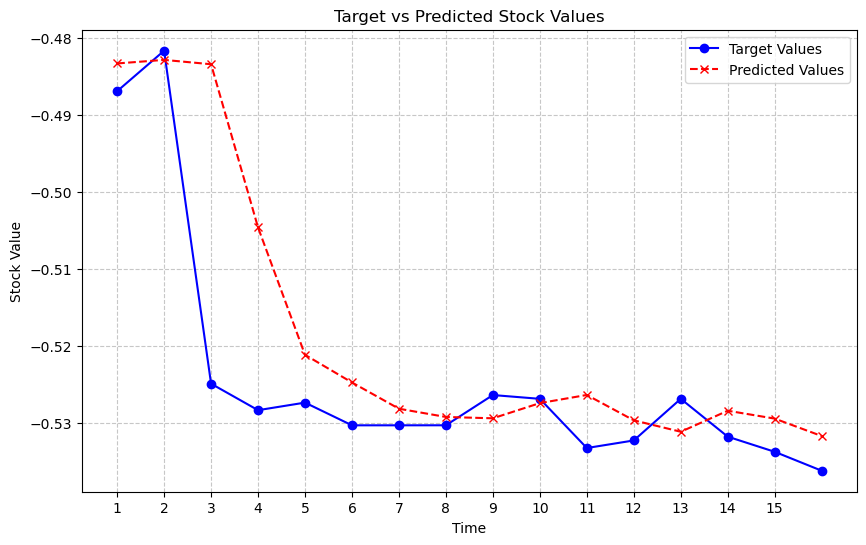

In [53]:
target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

print("\n\n-------------------------------------------------------------------------------")
print("Target Values vs Predicted Values: ")
print("Stock: ", stock_name)
print("Batch size: ", batch_size)
print("Target Values ", target_array)
print("Output Values ", output_array)
print("Test Loss: ", test_loss)
print("-------------------------------------------------------------------------------")

plot_target_vs_predicted_values(target_array, output_array, batch_size)



-------------------------------------------------------------------------------
Normalized mean target values and predicted values to equal 0: 
Shifted predicted values 1 to the left
Target differnce of begining and end stock price: $ -0.04936543107032776
Predicted differnce of begining and end stock price: $ -0.048925966024398804
-------------------------------------------------------------------------------


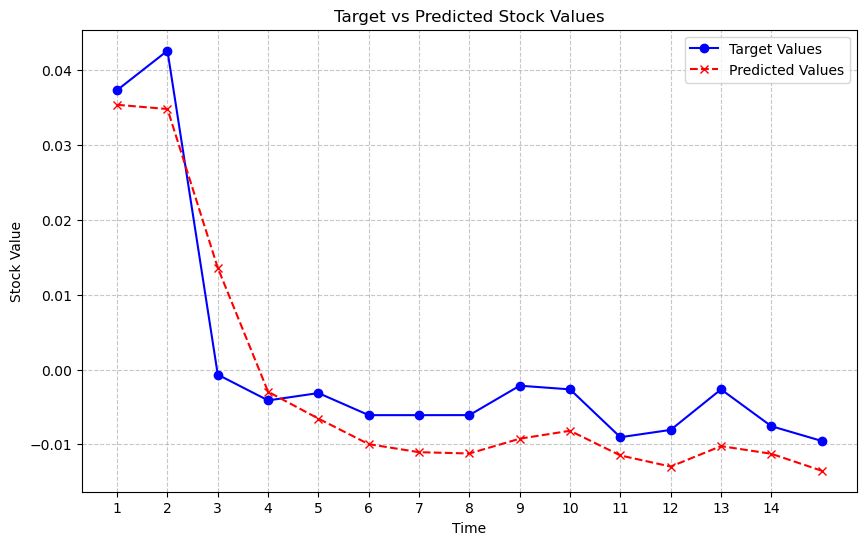

In [54]:
target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

target_sum = 0
for i in target_array:
    target_sum += i
target_average = target_sum / len(target_array)

for i in range(len(target_array)):
    target_array[i] -= target_average

output_sum = 0
for i in output_array:
    output_sum += i
output_average = output_sum / len(output_array)

for i in range(len(output_array)):
    output_array[i] -= output_average

for i in range(len(output_array) - 1):
    output_array[i] = output_array[i + 1]

print("\n\n-------------------------------------------------------------------------------")
print("Normalized mean target values and predicted values to equal 0: ")
print("Shifted predicted values 1 to the left")
print("Target differnce of begining and end stock price: $", target_array[-1] - target_array[0])
print("Predicted differnce of begining and end stock price: $", output_array[-1] - output_array[0])
print("-------------------------------------------------------------------------------")



plot_target_vs_predicted_values(target_array[0:batch_size-1], output_array[0:batch_size-1], batch_size - 1)



# First batch testing on optimized LR hyperparameter

tensor([0.1833, 0.1789, 0.1806, 0.2049, 0.2319, 0.2449, 0.2383, 0.2392, 0.2419,
        0.2406, 0.2423, 0.2322, 0.2303, 0.2334, 0.2123, 0.2063],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([0.1735, 0.1784, 0.2202, 0.2424, 0.2463, 0.2256, 0.2379, 0.2375, 0.2355,
        0.2389, 0.2188, 0.2276, 0.2301, 0.1907, 0.2035, 0.2084],
       device='cuda:0')
Output shape: torch.Size([16])
Target shape: torch.Size([16])
Test Loss: 0.000894



-------------------------------------------------------------------------------
Target Values vs Predicted Values: 
Stock:  AMD
Batch size:  16
Target Values  [0.1734728366136551, 0.178394615650177, 0.22022974491119385, 0.24237774312496185, 0.24631516635417938, 0.22564369440078735, 0.23794814944267273, 0.23745596408843994, 0.23548725247383118, 0.2389325052499771, 0.21875320374965668, 0.22761240601539612, 0.23007330298423767, 0.19069905579090118, 0.20349569618701935, 0.20841747522354126]
Output Values  [0.1832762509584427, 0.1789373755455017, 0

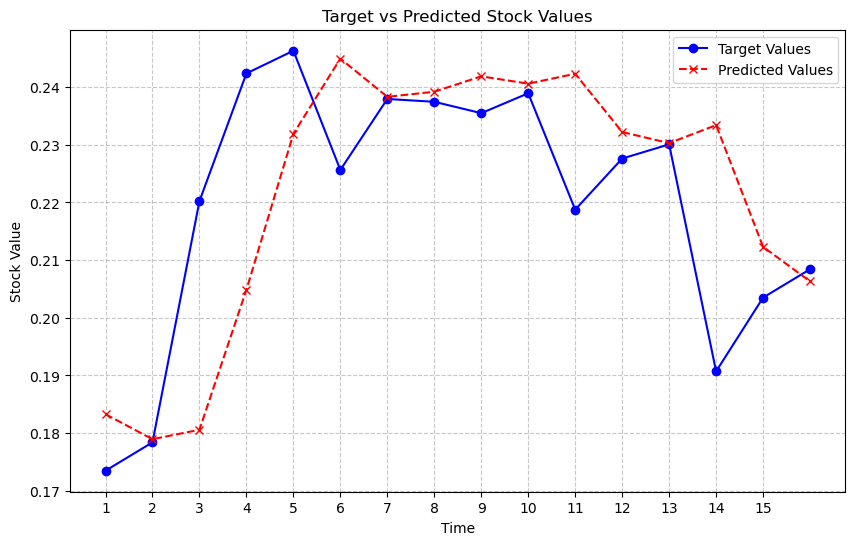



-------------------------------------------------------------------------------
Normalized mean target values and predicted values to equal 0: 
Shifted predicted values 1 to the left
Target differnce of begining and end stock price: $ 0.03494463860988617
Predicted differnce of begining and end stock price: $ 0.027369365096092224
-------------------------------------------------------------------------------


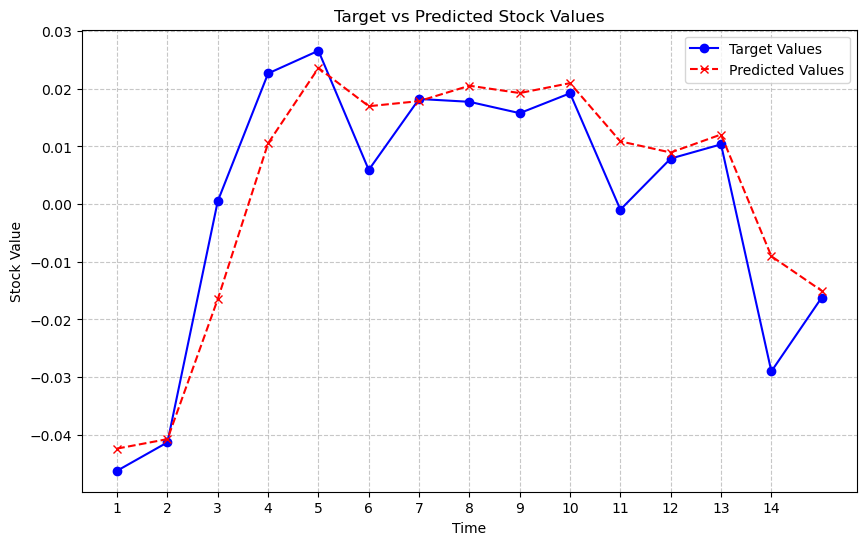

In [55]:
total_loss = 0
#iterate over test data
test_data = iter(optRNN_lr_Setup[0].test_loader)
data, target = next(test_data)
if train_on_gpu:
    data, target = data.cuda(), target.cuda()
#forward pass: compute predicted outputs by passing inputs to the model
output = optRNN_lr[0](data)
print(output)
print(target)
print("Output shape:", output.shape)
print("Target shape:", target.shape)
#calculate the batch loss
loss = error(output, target)
#update test loss
total_loss += loss.item()
test_loss += loss.item()/batch_size
#calculate test accuracy for each object class
#value_correct += 1

#average test loss
#test_loss = test_loss/len(optRNN_lr[0].test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

print("\n\n-------------------------------------------------------------------------------")
print("Target Values vs Predicted Values: ")
print("Stock: ", stock_name)
print("Batch size: ", batch_size)
print("Target Values ", target_array)
print("Output Values ", output_array)
print("Test Loss: ", test_loss)
print("-------------------------------------------------------------------------------")

plot_target_vs_predicted_values(target_array, output_array, batch_size)

target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

target_sum = 0
for i in target_array:
    target_sum += i
target_average = target_sum / len(target_array)

for i in range(len(target_array)):
    target_array[i] -= target_average

output_sum = 0
for i in output_array:
    output_sum += i
output_average = output_sum / len(output_array)

for i in range(len(output_array)):
    output_array[i] -= output_average

for i in range(len(output_array) - 1):
    output_array[i] = output_array[i + 1]

print("\n\n-------------------------------------------------------------------------------")
print("Normalized mean target values and predicted values to equal 0: ")
print("Shifted predicted values 1 to the left")
print("Target differnce of begining and end stock price: $", target_array[-1] - target_array[0])
print("Predicted differnce of begining and end stock price: $", output_array[-1] - output_array[0])
print("-------------------------------------------------------------------------------")



plot_target_vs_predicted_values(target_array[0:batch_size-1], output_array[0:batch_size-1], batch_size - 1)


# Full test dataset on Trained RNN with lowest loss hyperparameters in respect to the control
opt_lr, best_beta1, best_beta2, best_epoch, best_seq

Epoch 1/150, Training Loss: 0.016328, Validation Loss: 0.160489
Validation loss decreased (inf --> 0.007325).  Saving model ...
Epoch 11/150, Training Loss: 0.018255, Validation Loss: 0.001041
Validation loss decreased (0.007325 --> 0.003898).  Saving model ...
Epoch 21/150, Training Loss: 0.008069, Validation Loss: 0.000661
Validation loss decreased (0.003898 --> 0.002588).  Saving model ...
Epoch 31/150, Training Loss: 0.004097, Validation Loss: 0.000469
Validation loss decreased (0.002588 --> 0.001937).  Saving model ...
Epoch 41/150, Training Loss: 0.002273, Validation Loss: 0.000381
Validation loss decreased (0.001937 --> 0.001627).  Saving model ...
Epoch 51/150, Training Loss: 0.001497, Validation Loss: 0.000346
Validation loss decreased (0.001627 --> 0.001519).  Saving model ...
Epoch 61/150, Training Loss: 0.001297, Validation Loss: 0.000355
Validation loss decreased (0.001519 --> 0.001461).  Saving model ...
Epoch 71/150, Training Loss: 0.001287, Validation Loss: 0.000357
Val

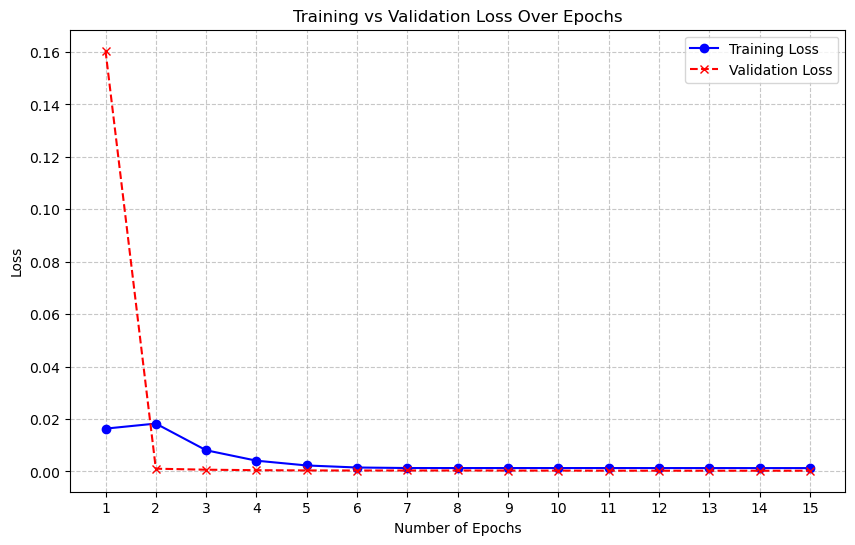

In [62]:
skip_this_step = False
if not skip_this_step:
    BEST_paramSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], 
    batch_size=batch_size, sequence_len=best_seq[0][1], num_workers=num_workers, epochs=best_epoch, learning_rate=opt_lr[0][1], 
    lr_scheduler_rate=lr_scheduler_rate, beta1=best_beta1[0][1], beta2=best_beta2[0][1])
    BEST_paramRNN = BEST_paramSetup.init_RNN()
    #returns
    training_loss_array = []
    validation_loss_array = []
    loss = BEST_paramSetup.trainAndTest(BEST_paramRNN)
    plot_loss(training_loss_array, validation_loss_array, epochs)

In [68]:
test_loss = 0.0
value_correct = 0
error = nn.MSELoss()

print("\n\n-------------------------------------------------------------------------------")
print("Learning rate: ", best_lr[0][1])
print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", best_epoch[0][1])
print("Learning rate scheduler rate: ", lr_scheduler_rate)
print("Beta1: ", best_beta1[0][1], "Beta2: ", best_beta2[0][1])
print("Sequence: ", best_seq[0][1])
print("-------------------------------------------------------------------------------")
BEST_paramRNN.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(BEST_paramSetup.test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = BEST_paramRNN(data)
    # calculate the batch loss
    loss = error(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # compare predictions to true label
    correct_tensor = output.eq(target.data.view_as(output))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    value_correct += 1
        
# average test loss
test_loss = test_loss/len(BEST_paramSetup.test_loader.dataset)
print('Average Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: %f (%2d/%2d)' % (value_correct/len(BEST_paramSetup.test_loader.dataset),
    value_correct, len(BEST_paramSetup.test_loader.dataset)))



-------------------------------------------------------------------------------
Learning rate:  1e-05
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  200
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.99
Sequence:  8
-------------------------------------------------------------------------------
Average Test Loss: 0.000847

Test Accuracy: 0.062580 (195/3116)




-------------------------------------------------------------------------------
Target Values vs Predicted Values: 
Stock:  AMD
Batch size:  16
Target Values  [-0.5273885726928711, -0.5303416848182678, -0.5303416848182678, -0.5303367376327515, -0.5264042615890503, -0.5268964171409607, -0.5332947373390198, -0.5323103666305542, -0.5268964171409607, -0.5318182110786438, -0.5337868928909302, -0.5362477898597717]
Output Values  [-0.520141065120697, -0.5205394625663757, -0.5211861729621887, -0.5199716091156006, -0.5191213488578796, -0.5156264901161194, -0.5153684020042419, -0.5204541087150574, -0.5218231081962585, -0.5175179243087769, -0.5194360017776489, -0.5222898125648499]
Test Loss:  0.0008468978591242372
-------------------------------------------------------------------------------


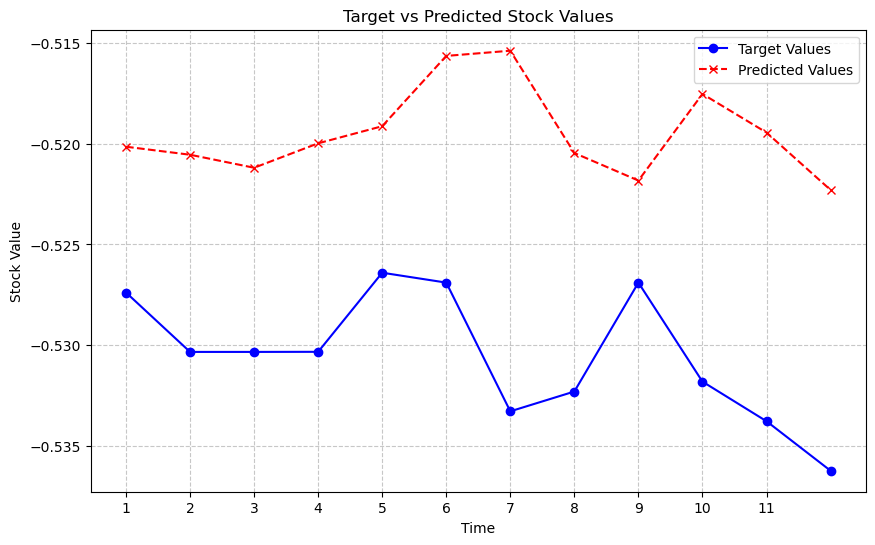

In [69]:
target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

print("\n\n-------------------------------------------------------------------------------")
print("Target Values vs Predicted Values: ")
print("Stock: ", stock_name)
print("Batch size: ", batch_size)
print("Target Values ", target_array)
print("Output Values ", output_array)
print("Test Loss: ", test_loss)
print("-------------------------------------------------------------------------------")

plot_target_vs_predicted_values(target_array, output_array, len(target_array))

# First batch testing with lowest loss hyperparameters in respect to the control

tensor([0.2546, 0.2646, 0.2469, 0.2466, 0.2479, 0.2464, 0.2494, 0.2349, 0.2354,
        0.2398, 0.2104, 0.2083, 0.2164, 0.2096, 0.2113, 0.2180],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([0.2463, 0.2256, 0.2379, 0.2375, 0.2355, 0.2389, 0.2188, 0.2276, 0.2301,
        0.1907, 0.2035, 0.2084, 0.1956, 0.2020, 0.2074, 0.2005],
       device='cuda:0')
Output shape: torch.Size([16])
Target shape: torch.Size([16])
Test Loss: 0.000871



-------------------------------------------------------------------------------
Target Values vs Predicted Values: 
Stock:  AMD
Batch size:  16
Target Values  [0.24631516635417938, 0.22564369440078735, 0.23794814944267273, 0.23745596408843994, 0.23548725247383118, 0.2389325052499771, 0.21875320374965668, 0.22761240601539612, 0.23007330298423767, 0.19069905579090118, 0.20349569618701935, 0.20841747522354126, 0.1956208497285843, 0.20201915502548218, 0.20743311941623688, 0.2005426287651062]
Output Values  [0.2545699179172516, 0.26462322473526, 0.

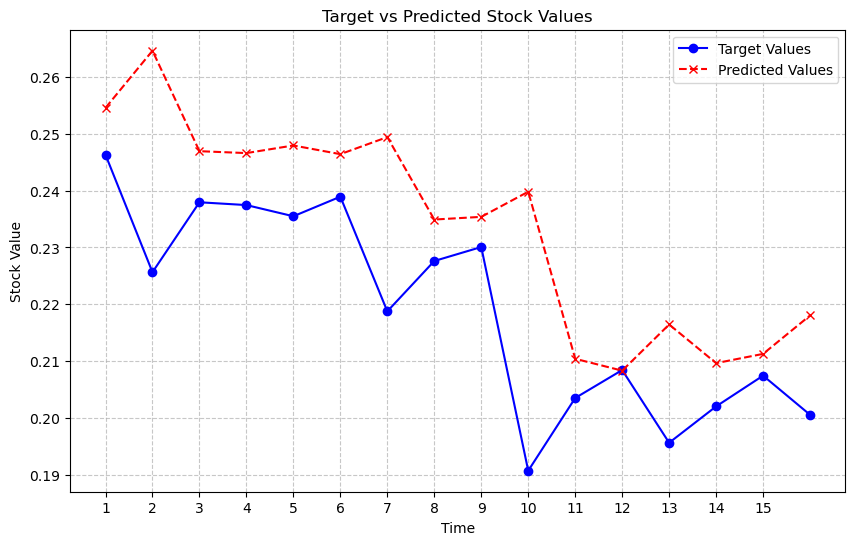



-------------------------------------------------------------------------------
Normalized mean target values and predicted values to equal 0: 
Shifted predicted values 1 to the left
Target differnce of begining and end stock price: $ -0.04577253758907318
Predicted differnce of begining and end stock price: $ -0.04659830033779144
-------------------------------------------------------------------------------


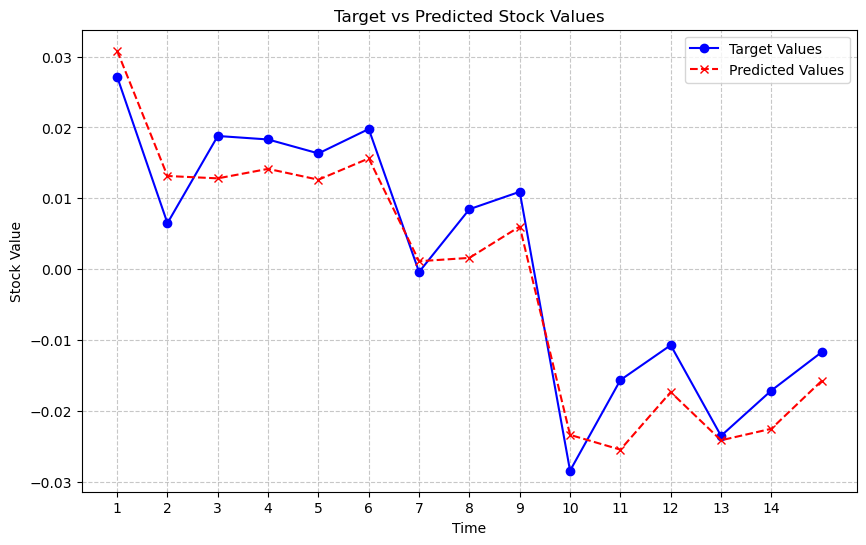

In [72]:
total_loss = 0
#iterate over test data
test_data = iter(BEST_paramSetup.test_loader)
data, target = next(test_data)
if train_on_gpu:
    data, target = data.cuda(), target.cuda()
#forward pass: compute predicted outputs by passing inputs to the model
output = BEST_paramRNN(data)
print(output)
print(target)
print("Output shape:", output.shape)
print("Target shape:", target.shape)
#calculate the batch loss
loss = error(output, target)
#update test loss
total_loss += loss.item()
test_loss += loss.item()/batch_size
#calculate test accuracy for each object class
#value_correct += 1

#average test loss
#test_loss = test_loss/len(optRNN_lr[0].test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

print("\n\n-------------------------------------------------------------------------------")
print("Target Values vs Predicted Values: ")
print("Stock: ", stock_name)
print("Batch size: ", batch_size)
print("Target Values ", target_array)
print("Output Values ", output_array)
print("Test Loss: ", test_loss)
print("-------------------------------------------------------------------------------")

plot_target_vs_predicted_values(target_array, output_array, batch_size)

target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

target_sum = 0
for i in target_array:
    target_sum += i
target_average = target_sum / len(target_array)

for i in range(len(target_array)):
    target_array[i] -= target_average

output_sum = 0
for i in output_array:
    output_sum += i
output_average = output_sum / len(output_array)

for i in range(len(output_array)):
    output_array[i] -= output_average

for i in range(len(output_array) - 1):
    output_array[i] = output_array[i + 1]

print("\n\n-------------------------------------------------------------------------------")
print("Normalized mean target values and predicted values to equal 0: ")
print("Shifted predicted values 1 to the left")
print("Target differnce of begining and end stock price: $", target_array[-1] - target_array[0])
print("Predicted differnce of begining and end stock price: $", output_array[-1] - output_array[0])
print("-------------------------------------------------------------------------------")



plot_target_vs_predicted_values(target_array[0:batch_size-1], output_array[0:batch_size-1], batch_size - 1)
